## Customer Service Ticket Classification

In [23]:
import os
import json
import pandas as pd
from tqdm import tqdm
from mistralai import Mistral
from utils import clean_text, normalize_prediction
from dotenv import load_dotenv

In [24]:
load_dotenv() 
API_KEY = os.getenv("MISTRAL_API_KEY")
client = Mistral(api_key=API_KEY)

#### HuggingFace dataset

In [3]:
from datasets import load_dataset
ds = load_dataset("Tobi-Bueck/customer-support-tickets")

/Users/nathanpollet/Desktop/mistralAI/mistral_final/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
print(ds)

DatasetDict({
    train: Dataset({
        features: ['subject', 'body', 'answer', 'type', 'queue', 'priority', 'language', 'tag_1', 'tag_2', 'tag_3', 'tag_4', 'tag_5', 'tag_6', 'tag_7', 'tag_8'],
        num_rows: 20000
    })
})


In [5]:
df = ds['train'].to_pandas()
print(df.shape[0])  
df.head(2)

20000


,subject,body,answer,type,queue,priority,language,tag_1,tag_2,tag_3,tag_4,tag_5,tag_6,tag_7,tag_8
0,Unvorhergesehener Absturz der Datenanalyse-Pla...,Die Datenanalyse-Plattform brach unerwartet ab...,Ich werde Ihnen bei der Lösung des Problems he...,Incident,General Inquiry,low,de,Crash,Technical,Bug,Hardware,Resolution,Outage,Documentation,None
1,Customer Support Inquiry,Seeking information on digital strategies that...,We offer a variety of digital strategies and s...,Request,Customer Service,medium,en,Feedback,Sales,IT,Tech Support,None,None,None,None


## Predicting `queue` category from the ticket `text`

### Data Preprocessing

Combine Subject + Body

In [6]:
df["text"] = df["subject"].fillna("") + "\n" + df["body"].fillna("")
df["text"] = df["text"].str.strip() 

Clean + Drop Missing Queues

In [7]:
df = df.dropna(subset=["queue", "text"])  # drop rows without target or input

In [8]:
df["clean_text"] = df["text"].astype(str).apply(clean_text)

In [9]:
df.head(2)

,subject,body,answer,type,queue,priority,language,tag_1,tag_2,tag_3,tag_4,tag_5,tag_6,tag_7,tag_8,text,clean_text
0,Unvorhergesehener Absturz der Datenanalyse-Pla...,Die Datenanalyse-Plattform brach unerwartet ab...,Ich werde Ihnen bei der Lösung des Problems he...,Incident,General Inquiry,low,de,Crash,Technical,Bug,Hardware,Resolution,Outage,Documentation,None,Unvorhergesehener Absturz der Datenanalyse-Pla...,unvorhergesehener absturz der datenanalyse-pla...
1,Customer Support Inquiry,Seeking information on digital strategies that...,We offer a variety of digital strategies and s...,Request,Customer Service,medium,en,Feedback,Sales,IT,Tech Support,None,None,None,None,Customer Support Inquiry\nSeeking information ...,customer support inquiry seeking information o...


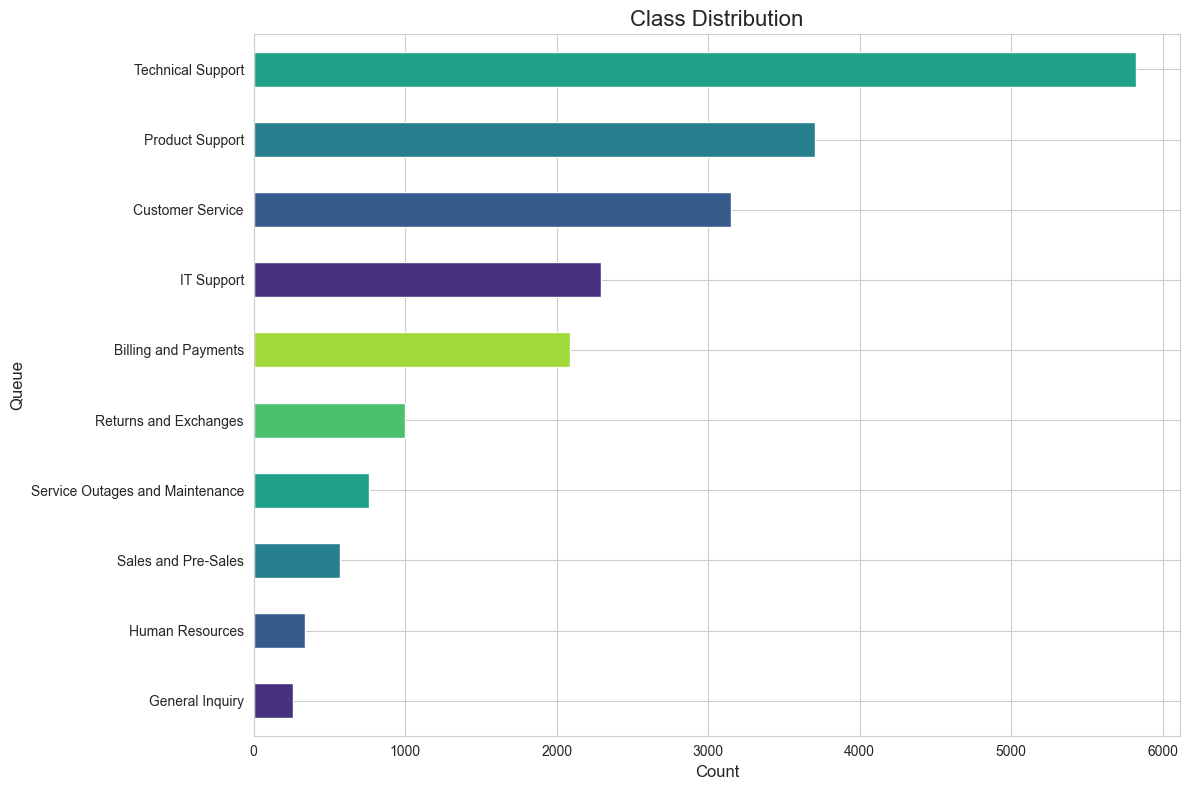

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
plt.figure(figsize=(12, 8))
df["queue"].value_counts().sort_values().plot(kind="barh", color=sns.color_palette("viridis"))
plt.title("Class Distribution", fontsize=16)
plt.ylabel("Queue", fontsize=12)
plt.xlabel("Count", fontsize=12)
plt.tight_layout()
plt.show()

### Dataset Splitting

In [11]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df["queue"], random_state=42)
print(f"train.shape: {train_df.shape}, test.shape: {test_df.shape}")

train.shape: (16000, 17), test.shape: (4000, 17)


Evaluation on Balanced Subset

In [ ]:
min_class_size = test_df["queue"].value_counts().min()
print(f"Minimum class size: {min_class_size}")

balanced_eval_df = (
    test_df.groupby("queue")
    .apply(lambda g: g.sample(min_class_size, random_state=42))
    .reset_index(drop=True)
)
print(balanced_eval_df.shape)

Minimum class size: 53
(530, 17)


/var/folders/nd/krrp0gv1723f5lj3w_6bpt8c0000gn/T/ipykernel_91774/818358947.py:6: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  test_df.groupby("queue")


### LLM Baselines

In [13]:
queue_list = sorted(df["queue"].dropna().unique().tolist()) 
print(queue_list) 

['Billing and Payments', 'Customer Service', 'General Inquiry', 'Human Resources', 'IT Support', 'Product Support', 'Returns and Exchanges', 'Sales and Pre-Sales', 'Service Outages and Maintenance', 'Technical Support']


In [18]:
def build_prompt(ticket_text, queue_list):
    return f"""You are a support triage assistant. Classify the following ticket into one of the queues listed.

-----
Ticket information:
{ticket_text}
-----

Possible queues: {", ".join(queue_list)}

What is the most appropriate queue for this ticket? Just output the name of the queue."""

In [19]:
print(build_prompt("My computer is not working,\nI cannot access my emails and the screen is black.", queue_list))

You are a support triage assistant. Classify the following ticket into one of the queues listed.

-----
Ticket information:
My computer is not working,
I cannot access my emails and the screen is black.
-----

Possible queues: Billing and Payments, Customer Service, General Inquiry, Human Resources, IT Support, Product Support, Returns and Exchanges, Sales and Pre-Sales, Service Outages and Maintenance, Technical Support

What is the most appropriate queue for this ticket? Just output the name of the queue.


In [25]:
def LLM_call(prompt, model="ministral-3b-2410"):
    client = Mistral(api_key=API_KEY)
    response = client.chat.complete(
        model=model,
        messages=[{"role": "user", "content": f"{prompt}"}],
    )

    return response.choices[0].message.content.strip()

In [26]:
response = LLM_call(build_prompt("My computer is not working\nI cannot access my emails and the screen is black.", queue_list))
print(response) 

IT Support


#### Zero-shot, Evaluating Various Model Performances

##### Evaluation on Balanced Subset

In [27]:
prompts = balanced_eval_df["text"].apply(lambda t: build_prompt(t, queue_list))

In [243]:
balanced_eval_df["ministral3b-zeroShot-preds"] = [LLM_call(p) for p in tqdm(prompts, desc="LLM calls")]
balanced_eval_df["ministral3b-zeroShot-preds-normalized"] = balanced_eval_df["ministral3b-zeroShot-preds"].apply(lambda x: normalize_prediction(x, queue_list))
assert "UNKNOWN" not in balanced_eval_df["ministral3b-zeroShot-preds-normalized"], "There are 'UNKNOWN' predictions, LLM output format error."

LLM calls: 100%|██████████| 530/530 [02:22<00:00,  3.71it/s]


In [35]:
print(f"accuracy = {accuracy_score(balanced_eval_df['queue'], balanced_eval_df['ministral3b-zeroShot-preds-normalized'])}")
macro_f1 = f1_score(balanced_eval_df["queue"], balanced_eval_df["ministral3b-zeroShot-preds-normalized"], average="macro")
weighted_f1 = f1_score(balanced_eval_df["queue"], balanced_eval_df["ministral3b-zeroShot-preds-normalized"], average="weighted")
print(f"Macro F1: {macro_f1:.4f}")
print(f"Weighted F1: {weighted_f1:.4f}")

accuracy = 0.2018867924528302
Macro F1: 0.1880
Weighted F1: 0.1880


In [36]:
print(
    classification_report(
        balanced_eval_df["queue"],
        balanced_eval_df["ministral3b-zeroShot-preds-normalized"],
        labels=queue_list,
    )
)

                                 precision    recall  f1-score   support

           Billing and Payments       1.00      0.42      0.59        53
               Customer Service       0.00      0.00      0.00        53
                General Inquiry       0.17      0.06      0.08        53
                Human Resources       1.00      0.19      0.32        53
                     IT Support       0.12      0.91      0.22        53
                Product Support       0.04      0.02      0.03        53
          Returns and Exchanges       0.00      0.00      0.00        53
            Sales and Pre-Sales       0.42      0.19      0.26        53
Service Outages and Maintenance       0.92      0.23      0.36        53
              Technical Support       0.04      0.02      0.02        53

                       accuracy                           0.20       530
                      macro avg       0.37      0.20      0.19       530
                   weighted avg       0.37      0

/Users/nathanpollet/Desktop/mistralAI/mistral_final/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/nathanpollet/Desktop/mistralAI/mistral_final/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/nathanpollet/Desktop/mistralAI/mistral_final/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

With mistral medium model

In [37]:
balanced_eval_df["mistralmedium-zeroShot-preds"] = [LLM_call(p, model="mistral-medium-2505") for p in tqdm(prompts, desc="LLM calls")]
balanced_eval_df["mistralmedium-zeroShot-preds-normalized"] = balanced_eval_df["mistralmedium-zeroShot-preds"].apply(lambda x: normalize_prediction(x, queue_list))

assert "UNKNOWN" not in balanced_eval_df["mistralmedium-zeroShot-preds-normalized"], "There are 'UNKNOWN' predictions, LLM output format error."

LLM calls: 100%|██████████| 530/530 [03:18<00:00,  2.67it/s]


In [40]:
print(f"accuracy = {accuracy_score(balanced_eval_df['queue'], balanced_eval_df['mistralmedium-zeroShot-preds-normalized'])}")
macro_f1 = f1_score(balanced_eval_df["queue"], balanced_eval_df["mistralmedium-zeroShot-preds-normalized"], average="macro")
weighted_f1 = f1_score(balanced_eval_df["queue"], balanced_eval_df["mistralmedium-zeroShot-preds-normalized"], average="weighted")
print(f"Macro F1: {macro_f1:.4f}")
print(f"Weighted F1: {weighted_f1:.4f}") 

accuracy = 0.2641509433962264
Macro F1: 0.2631
Weighted F1: 0.2631


In [43]:
print(
    classification_report(
        balanced_eval_df["queue"],
        balanced_eval_df["mistralmedium-zeroShot-preds-normalized"],
        labels=queue_list,
    )
)

                                 precision    recall  f1-score   support

           Billing and Payments       1.00      0.47      0.64        53
               Customer Service       0.20      0.02      0.03        53
                General Inquiry       0.23      0.15      0.18        53
                Human Resources       1.00      0.21      0.34        53
                     IT Support       0.16      0.26      0.20        53
                Product Support       0.09      0.15      0.11        53
          Returns and Exchanges       0.00      0.00      0.00        53
            Sales and Pre-Sales       0.30      0.38      0.33        53
Service Outages and Maintenance       0.61      0.47      0.53        53
              Technical Support       0.17      0.53      0.26        53

                       accuracy                           0.26       530
                      macro avg       0.38      0.26      0.26       530
                   weighted avg       0.38      0

/Users/nathanpollet/Desktop/mistralAI/mistral_final/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/nathanpollet/Desktop/mistralAI/mistral_final/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/nathanpollet/Desktop/mistralAI/mistral_final/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

In [ ]:
balanced_eval_df.to_csv("./data/balanced_eval_df.csv")

##### Evaluation on Unbalanced Test set

In [181]:
prompts = test_df["text"].apply(lambda t: build_prompt(t, queue_list))

In [182]:
test_df["ministral-zeroShot-preds"] = [LLM_call(p) for p in tqdm(prompts, desc="LLM calls")] 
test_df["ministral-zeroShot-preds-normalized"] = test_df["ministral-zeroShot-preds"].apply(lambda x: normalize_prediction(x, queue_list)) 
assert "UNKNOWN" not in test_df["ministral-zeroShot-preds-normalized"], "There are 'UNKNOWN' predictions, LLM output format error."

LLM calls: 100%|██████████| 4000/4000 [16:53<00:00,  3.95it/s]  


In [183]:
print(f"accuracy = {accuracy_score(test_df['queue'], test_df['ministral-zeroShot-preds-normalized'])}")
macro_f1 = f1_score(test_df["queue"], test_df["ministral-zeroShot-preds-normalized"], average="macro")
weighted_f1 = f1_score(test_df["queue"], test_df["ministral-zeroShot-preds-normalized"], average="weighted")
print(f"Macro F1: {macro_f1:.4f}")
print(f"Weighted F1: {weighted_f1:.4f}") 

accuracy = 0.1785
Macro F1: 0.1638
Weighted F1: 0.1331


In [184]:
print(
    classification_report(
        test_df["queue"],
        test_df["ministral-zeroShot-preds-normalized"],
        labels=queue_list,
    )
)

                                 precision    recall  f1-score   support

           Billing and Payments       0.99      0.41      0.58       417
               Customer Service       0.19      0.00      0.01       630
                General Inquiry       0.02      0.06      0.03        53
                Human Resources       0.92      0.18      0.30        68
                     IT Support       0.14      0.93      0.24       458
                Product Support       0.18      0.04      0.06       742
          Returns and Exchanges       1.00      0.01      0.03       200
            Sales and Pre-Sales       0.08      0.12      0.10       114
Service Outages and Maintenance       0.74      0.15      0.25       153
              Technical Support       0.20      0.03      0.05      1165

                       accuracy                           0.18      4000
                      macro avg       0.45      0.19      0.16      4000
                   weighted avg       0.34      0

With mistral medium model

In [186]:
test_df["mistral-medium-zeroShot-preds"] = [LLM_call(p, model="mistral-medium-2505") for p in tqdm(prompts, desc="LLM calls")] 
test_df["mistral-medium-zeroShot-preds-normalized"] = test_df["mistral-medium-zeroShot-preds"].apply(lambda x: normalize_prediction(x, queue_list)) 
assert "UNKNOWN" not in test_df["mistral-medium-zeroShot-preds-normalized"], "There are 'UNKNOWN' predictions, LLM output format error."

LLM calls: 100%|██████████| 4000/4000 [29:52<00:00,  2.23it/s]  


In [189]:
print(f"accuracy = {accuracy_score(test_df['queue'], test_df['mistral-medium-zeroShot-preds-normalized'])}")
macro_f1 = f1_score(test_df["queue"], test_df["mistral-medium-zeroShot-preds-normalized"], average="macro")
weighted_f1 = f1_score(test_df["queue"], test_df["mistral-medium-zeroShot-preds-normalized"], average="weighted")
print(f"Macro F1: {macro_f1:.4f}")
print(f"Weighted F1: {weighted_f1:.4f}") 

accuracy = 0.29725
Macro F1: 0.2354
Weighted F1: 0.2829


In [190]:
print(
    classification_report(
        test_df["queue"],
        test_df["mistral-medium-zeroShot-preds-normalized"],
        labels=queue_list,
    )
)

                                 precision    recall  f1-score   support

           Billing and Payments       0.99      0.44      0.61       417
               Customer Service       0.22      0.01      0.01       630
                General Inquiry       0.04      0.17      0.07        53
                Human Resources       1.00      0.19      0.32        68
                     IT Support       0.15      0.23      0.18       458
                Product Support       0.24      0.20      0.22       742
          Returns and Exchanges       1.00      0.01      0.03       200
            Sales and Pre-Sales       0.07      0.25      0.11       114
Service Outages and Maintenance       0.28      0.48      0.35       153
              Technical Support       0.40      0.53      0.46      1165

                       accuracy                           0.30      4000
                      macro avg       0.44      0.25      0.24      4000
                   weighted avg       0.39      0

### Improved Prompt & Few Shot

In [191]:
def build_prompt_fewShot(ticket_text, queue_list, fewshot_text):
    return f"""You are a support triage assistant. Classify the following IT ticket into one of the queues listed.

-----
Ticket information:
{ticket_text}
-----

Possible queues: {", ".join(queue_list)}

Queue Details:
Technical Support: Technical issues and support requests.
Customer Service: Customer inquiries and service requests.
Billing and Payments: Billing issues and payment processing.
Product Support: Support for product-related issues.
IT Support: Internal IT support and infrastructure issues.
Returns and Exchanges: Product returns and exchanges.
Sales and Pre-Sales: Sales inquiries and pre-sales questions.
Human Resources: Employee inquiries and HR-related issues.
Service Outages and Maintenance: Service interruptions and maintenance.
General Inquiry: General inquiries and information requests.

-----
Here are some examples:
{fewshot_text}
-----

What is the most appropriate queue for this ticket? Just output the name of the queue."""

In [192]:
fewshot_df = (
    train_df.groupby("queue", group_keys=False)
    .apply(lambda x: x.sample(1, random_state=42))
    .sample(3, random_state=42)  # ensure we only pick 3 in total
    .reset_index(drop=True)
)

def format_fewshot_examples(fewshot_df):
    examples = []
    for _, row in fewshot_df.iterrows():
        example = f"""Example:
Subject: {row['subject']}
Body: {row['body']}
Queue: {row['queue']}"""
        examples.append(example)
    return "\n\n".join(examples)

fewshot_text = format_fewshot_examples(fewshot_df)
print(fewshot_text)

Example:
Subject: Concerns About Service Outages
Body: There were sporadic service outages impacting several applications, which might be related to recent updates or server overload. We have restarted the affected services and are keeping an eye on the server load.
Queue: Service Outages and Maintenance

Example:
Subject: Unterstützung für Datensicherheitslösungen erforderlich
Body: Bitte geben Sie Details zu Datensicherheitslösungen an.
Queue: Customer Service

Example:
Subject: Request for Guidance on Jenkins Integration
Body: I am contacting you to seek guidance on integrating Jenkins with your project management SaaS solution. Could you share any pertinent information regarding this integration? I would greatly value any available documentation or instructional materials. Specifically, I am keen to understand the advantages and potential obstacles associated with using Jenkins in conjunction with your platform. I am looking forward to your response and to exploring ways to optimiz

/var/folders/nd/krrp0gv1723f5lj3w_6bpt8c0000gn/T/ipykernel_1240/1664327731.py:2: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train_df.groupby("queue", group_keys=False)


##### Evaluation on Balanced Subset

ministral-3b

In [217]:
prompts = balanced_eval_df["text"].apply(lambda t: build_prompt_fewShot(t, queue_list, fewshot_text))

In [77]:
balanced_eval_df["ministral3b-fewShot-preds"] = [LLM_call(p) for p in tqdm(prompts, desc="LLM calls")]
balanced_eval_df["ministral3b-fewShot-preds-normalized"] = balanced_eval_df["ministral3b-fewShot-preds"].apply(lambda x: normalize_prediction(x, queue_list))
assert "UNKNOWN" not in balanced_eval_df["ministral3b-fewShot-preds-normalized"], "There are 'UNKNOWN' predictions, LLM output format error."

LLM calls: 100%|██████████| 530/530 [02:02<00:00,  4.33it/s]


In [80]:
print(f"accuracy = {accuracy_score(balanced_eval_df['queue'], balanced_eval_df['ministral3b-fewShot-preds-normalized'])}")
macro_f1 = f1_score(balanced_eval_df["queue"], balanced_eval_df["ministral3b-fewShot-preds-normalized"], average="macro")
weighted_f1 = f1_score(balanced_eval_df["queue"], balanced_eval_df["ministral3b-fewShot-preds-normalized"], average="weighted")
print(f"Macro F1: {macro_f1:.4f}")
print(f"Weighted F1: {weighted_f1:.4f}")

accuracy = 0.2188679245283019
Macro F1: 0.2243
Weighted F1: 0.2243


Mistral Small 3.2

In [94]:
balanced_eval_df["mistral-medium-fewShot-preds"] = [
    LLM_call(p, model="mistral-medium-2505") for p in tqdm(prompts, desc="LLM calls")
]
balanced_eval_df["mistral-medium-fewShot-preds-normalized"] = balanced_eval_df["mistral-medium-fewShot-preds"].apply(lambda x: normalize_prediction(x, queue_list))
assert "UNKNOWN" not in balanced_eval_df["mistral-medium-fewShot-preds-normalized"], "There are 'UNKNOWN' predictions, LLM output format error."

LLM calls: 100%|██████████| 530/530 [05:19<00:00,  1.66it/s]


In [95]:
print(f"accuracy = {accuracy_score(balanced_eval_df['queue'], balanced_eval_df['mistral-medium-fewShot-preds-normalized'])}")
macro_f1 = f1_score(balanced_eval_df["queue"], balanced_eval_df["mistral-medium-fewShot-preds-normalized"], average="macro")
weighted_f1 = f1_score(balanced_eval_df["queue"], balanced_eval_df["mistral-medium-fewShot-preds-normalized"], average="weighted")
print(f"Macro F1: {macro_f1:.4f}")
print(f"Weighted F1: {weighted_f1:.4f}")

accuracy = 0.2622641509433962
Macro F1: 0.2640
Weighted F1: 0.2640


##### Evaluation on Unbalanced Test set

ministral-3b

In [200]:
prompts = test_df["text"].apply(lambda t: build_prompt_fewShot(t, queue_list, fewshot_text))

In [207]:
test_df["ministral3b-fewShot-preds"] = [LLM_call(p) for p in tqdm(prompts, desc="LLM calls")]
test_df["ministral3b-fewShot-preds-normalized"] = test_df["ministral3b-fewShot-preds"].apply(lambda x: normalize_prediction(x, queue_list))
assert "UNKNOWN" not in test_df["ministral3b-fewShot-preds-normalized"], "There are 'UNKNOWN' predictions, LLM output format error."

LLM calls:   0%|          | 0/4000 [00:00<?, ?it/s]

LLM calls: 100%|██████████| 4000/4000 [16:27<00:00,  4.05it/s]  


In [209]:
print(f"accuracy = {accuracy_score(test_df['queue'], test_df['ministral3b-fewShot-preds-normalized'])}")
macro_f1 = f1_score(test_df["queue"], test_df["ministral3b-fewShot-preds-normalized"], average="macro")
weighted_f1 = f1_score(test_df["queue"], test_df["ministral3b-fewShot-preds-normalized"], average="weighted")
print(f"Macro F1: {macro_f1:.4f}")
print(f"Weighted F1: {weighted_f1:.4f}")

accuracy = 0.21125
Macro F1: 0.1973
Weighted F1: 0.1998


Mistral Small 3.2

In [210]:
test_df["mistral-medium-fewShot-preds"] = [
    LLM_call(p, model="mistral-medium-2505") for p in tqdm(prompts, desc="LLM calls")
]
test_df["mistral-medium-fewShot-preds-normalized"] = test_df["mistral-medium-fewShot-preds"].apply(lambda x: normalize_prediction(x, queue_list))
assert "UNKNOWN" not in test_df["mistral-medium-fewShot-preds-normalized"], "There are 'UNKNOWN' predictions, LLM output format error."

LLM calls: 100%|██████████| 4000/4000 [31:06<00:00,  2.14it/s]  


In [212]:
print(f"accuracy = {accuracy_score(test_df['queue'], test_df['mistral-medium-fewShot-preds-normalized'])}")
macro_f1 = f1_score(test_df["queue"], test_df["mistral-medium-fewShot-preds-normalized"], average="macro")
weighted_f1 = f1_score(test_df["queue"], test_df["mistral-medium-fewShot-preds-normalized"], average="weighted")
print(f"Macro F1: {macro_f1:.4f}")
print(f"Weighted F1: {weighted_f1:.4f}")

accuracy = 0.301
Macro F1: 0.2482
Weighted F1: 0.2913


### LLM Finetuning 

#### Data Preparation

#### `Ministral-3B` Completion Finetuning

In [ ]:
def clean_str(text):
    if not isinstance(text, str):
        return ""
    return text.replace("\n", " ").strip()

preprompt = f"You are a support triage assistant. Classify the following IT ticket into one of the queues listed.\n\n"

def to_completion_format(row):
    user_prompt = f"{preprompt}-----\nTicket information:\nSubject: {clean_str(row['subject'])}\nBody: {clean_str(row['body'])}\n-----\n\nPossible queues: {', '.join(sorted(train_df['queue'].dropna().unique()))}\n\nWhat is the most appropriate queue for this ticket? Just output the name of the queue."
    return {
        "messages": [
            {"role": "user", "content": user_prompt},
            {"role": "assistant", "content": row['queue']}
        ]
    }

completion_data = [to_completion_format(row) for _, row in train_df.iterrows()] 
with open("./finetuning-data/mistral_completion_finetune_train_10072025.jsonl", "w", encoding="utf-8") as f:
    for item in completion_data:
        f.write(json.dumps(item, ensure_ascii=False) + "\n")

In [ ]:
completion_data = [to_completion_format(row) for _, row in test_df.iterrows()]
with open("/finetuning-data/mistral_completion_finetune_test_10072025.jsonl", "w", encoding="utf-8") as f:
    for item in completion_data:
        f.write(json.dumps(item, ensure_ascii=False) + "\n") 

Using this data and the Mistral Finetuning API (via Web) to finetune a ministral-3B model for completion.
- 5 epochs
- learning rate: 1e-5
- 14,921,125 training tokens

#### Testing finetuned ministral-3B

On balanced eval set

In [134]:
prompts = balanced_eval_df["text"].apply(lambda t: build_prompt(t, queue_list))

In [135]:
balanced_eval_df["ministral-finetuned-zeroShot-preds"] = [
    LLM_call(p, model="ft:ministral-3b-latest:9bdff429:20250709:8369d014")
    for p in tqdm(prompts, desc="LLM calls")
]
balanced_eval_df["ministral-finetuned-zeroShot-preds-normalized"] = balanced_eval_df["ministral-finetuned-zeroShot-preds"].apply(lambda x: normalize_prediction(x, queue_list))
assert ("UNKNOWN" not in balanced_eval_df["ministral-finetuned-zeroShot-preds-normalized"]), "There are 'UNKNOWN' predictions, LLM output format error."

LLM calls: 100%|██████████| 530/530 [03:02<00:00,  2.90it/s]


In [138]:
print(f"accuracy = {accuracy_score(balanced_eval_df['queue'], balanced_eval_df['ministral-finetuned-zeroShot-preds-normalized'])}")
macro_f1 = f1_score(balanced_eval_df["queue"], balanced_eval_df["ministral-finetuned-zeroShot-preds-normalized"], average="macro")
weighted_f1 = f1_score(balanced_eval_df["queue"], balanced_eval_df["ministral-finetuned-zeroShot-preds-normalized"], average="weighted")
print(f"Macro F1: {macro_f1:.4f}")
print(f"Weighted F1: {weighted_f1:.4f}")

accuracy = 0.25471698113207547
Macro F1: 0.2453
Weighted F1: 0.2453


On unbalanced test set

In [149]:
prompts = test_df["text"].apply(lambda t: build_prompt(t, queue_list))

In [150]:
test_df["ministral-finetuned-zeroShot-preds"] = [
    LLM_call(p, model="ft:ministral-3b-latest:9bdff429:20250709:8369d014")
    for p in tqdm(prompts, desc="LLM calls")
]
test_df["ministral-finetuned-zeroShot-preds-normalized"] = test_df["ministral-finetuned-zeroShot-preds"].apply(lambda x: normalize_prediction(x, queue_list))
assert ("UNKNOWN" not in test_df["ministral-finetuned-zeroShot-preds-normalized"]), "There are 'UNKNOWN' predictions, LLM output format error."

LLM calls: 100%|██████████| 4000/4000 [22:35<00:00,  2.95it/s]  


In [151]:
print(f"accuracy = {accuracy_score(test_df['queue'], test_df['ministral-finetuned-zeroShot-preds-normalized'])}")
macro_f1 = f1_score(test_df["queue"], test_df["ministral-finetuned-zeroShot-preds-normalized"], average="macro")
weighted_f1 = f1_score(test_df["queue"], test_df["ministral-finetuned-zeroShot-preds-normalized"], average="weighted")
print(f"Macro F1: {macro_f1:.4f}")
print(f"Weighted F1: {weighted_f1:.4f}")

accuracy = 0.38325
Macro F1: 0.2687
Weighted F1: 0.3352


#### Testing finetuned mistral-medium

Using this data and the Mistral Finetuning API (via Web) to finetune a ministral-3B model for completion.
- 4 epochs
- learning rate: 1e-5
- 11,936,900 tokens training tokens

On balanced eval set

In [152]:
prompts = balanced_eval_df["text"].apply(lambda t: build_prompt(t, queue_list))

In [153]:
balanced_eval_df["mistral-medium-finetuned-zeroShot-preds"] = [
    LLM_call(p, model="ft:mistral-medium-latest:9bdff429:20250709:9bdbabc3")
    for p in tqdm(prompts, desc="LLM calls")
]
balanced_eval_df["mistral-medium-finetuned-zeroShot-preds-normalized"] = balanced_eval_df["mistral-medium-finetuned-zeroShot-preds"].apply(lambda x: normalize_prediction(x, queue_list))
assert ("UNKNOWN" not in balanced_eval_df["mistral-medium-finetuned-zeroShot-preds-normalized"]), "There are 'UNKNOWN' predictions, LLM output format error."

LLM calls: 100%|██████████| 530/530 [08:19<00:00,  1.06it/s]


In [154]:
print(f"accuracy = {accuracy_score(balanced_eval_df['queue'], balanced_eval_df['mistral-medium-finetuned-zeroShot-preds-normalized'])}")
macro_f1 = f1_score(balanced_eval_df["queue"], balanced_eval_df["mistral-medium-finetuned-zeroShot-preds-normalized"], average="macro")
weighted_f1 = f1_score(balanced_eval_df["queue"], balanced_eval_df["mistral-medium-finetuned-zeroShot-preds-normalized"], average="weighted")
print(f"Macro F1: {macro_f1:.4f}")
print(f"Weighted F1: {weighted_f1:.4f}")

accuracy = 0.27169811320754716
Macro F1: 0.2550
Weighted F1: 0.2550


In [155]:
balanced_eval_df.to_csv("./data/balanced_eval_with_predictions2.csv")

On unbalanced test set

In [156]:
prompts = test_df["text"].apply(lambda t: build_prompt(t, queue_list))

In [157]:
test_df["mistral-medium-finetuned-zeroShot-preds"] = [
    LLM_call(p, model="ft:mistral-medium-latest:9bdff429:20250709:9bdbabc3")
    for p in tqdm(prompts, desc="LLM calls")
]
test_df["mistral-medium-finetuned-zeroShot-preds-normalized"] = test_df["mistral-medium-finetuned-zeroShot-preds"].apply(lambda x: normalize_prediction(x, queue_list))
assert ("UNKNOWN" not in test_df["mistral-medium-finetuned-zeroShot-preds-normalized"]), "There are 'UNKNOWN' predictions, LLM output format error."

LLM calls: 100%|██████████| 4000/4000 [46:56<00:00,  1.42it/s]  


In [160]:
print(f"accuracy = {accuracy_score(test_df['queue'], test_df['mistral-medium-finetuned-zeroShot-preds-normalized'])}")
macro_f1 = f1_score(test_df["queue"], test_df["mistral-medium-finetuned-zeroShot-preds-normalized"], average="macro")
weighted_f1 = f1_score(test_df["queue"], test_df["mistral-medium-finetuned-zeroShot-preds-normalized"], average="weighted")
print(f"Macro F1: {macro_f1:.4f}")
print(f"Weighted F1: {weighted_f1:.4f}")

accuracy = 0.38775
Macro F1: 0.2657
Weighted F1: 0.3359


In [159]:
print(
    classification_report(
        test_df["queue"],
        test_df["mistral-medium-finetuned-zeroShot-preds-normalized"],
        labels=queue_list,
    )
)

                                 precision    recall  f1-score   support

           Billing and Payments       0.95      0.64      0.76       417
               Customer Service       0.27      0.21      0.23       630
                General Inquiry       0.00      0.00      0.00        53
                Human Resources       0.94      0.22      0.36        68
                     IT Support       0.37      0.02      0.04       458
                Product Support       0.24      0.20      0.22       742
          Returns and Exchanges       1.00      0.02      0.04       200
            Sales and Pre-Sales       0.17      0.03      0.05       114
Service Outages and Maintenance       0.60      0.36      0.45       153
              Technical Support       0.37      0.79      0.51      1165

                       accuracy                           0.39      4000
                      macro avg       0.49      0.25      0.27      4000
                   weighted avg       0.43      0

/Users/nathanpollet/Desktop/mistralAI/mistral_final/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/nathanpollet/Desktop/mistralAI/mistral_final/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/nathanpollet/Desktop/mistralAI/mistral_final/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

## Improved LLM Finetuning with Stratified Undersampling

In [168]:
print(train_df.shape)

# Stratified undersampling for balanced finetuning set
min_class_count = train_df["queue"].value_counts().min()
balanced_train_df = (
    train_df.groupby("queue")
    .sample(n=min_class_count, random_state=42)
    .reset_index(drop=True)
)
print(balanced_train_df.shape)

(16000, 18)
(2100, 18)


In [ ]:
def clean_str(text):
    if not isinstance(text, str):
        return ""
    return text.replace("\n", " ").strip()

preprompt = f"You are a support triage assistant. Classify the following IT ticket into one of the queues listed.\n\n"
queue_details = """Queue Details:
Technical Support: Technical issues and support requests.
Customer Service: Customer inquiries and service requests.
Billing and Payments: Billing issues and payment processing.
Product Support: Support for product-related issues.
IT Support: Internal IT support and infrastructure issues.
Returns and Exchanges: Product returns and exchanges.
Sales and Pre-Sales: Sales inquiries and pre-sales questions.
Human Resources: Employee inquiries and HR-related issues.
Service Outages and Maintenance: Service interruptions and maintenance.
General Inquiry: General inquiries and information requests."""

def to_completion_format(row):
    user_prompt = f"{preprompt}-----\nTicket information:\nSubject: {clean_str(row['subject'])}\nBody: {clean_str(row['body'])}\n-----\n\nPossible queues: {', '.join(sorted(train_df['queue'].dropna().unique()))}\n\n{queue_details}\n\nWhat is the most appropriate queue for this ticket? Just output the name of the queue."
    return {
        "messages": [
            {"role": "user", "content": user_prompt},
            {"role": "assistant", "content": row['queue']}
        ]
    }

completion_data = [to_completion_format(row) for _, row in balanced_train_df.iterrows()] 
with open("/finetuning-data/mistral_completion_finetune_train_balanced.jsonl", "w", encoding="utf-8") as f:
    for item in completion_data:
        f.write(json.dumps(item, ensure_ascii=False) + "\n")

In [ ]:
with open("/finetuning-data/mistral_completion_finetune_train_balanced.jsonl", "rb") as f:
    upload_response = client.files.upload(
        file={
            "file_name": "mistral_completion_finetune_train_balanced.jsonl",
            "content": f,
        }
    )

print(f"✅ Uploaded: {upload_response.id}")

✅ Uploaded: ca302b87-7b6a-4c9e-b3b1-6096cb662e6d


Could not perform finetuning job due to an issue with/in mistral's finetuning service.

## Non-LLM Baseline Model1: TF-IDF + Label Encoding + Logistic Regression

TF-IDF + Label Encoding

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, classification_report

In [ ]:
X_train = train_df["text"]
y_train = train_df["queue"]
X_test = test_df["text"]
y_test = test_df["queue"]

vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

label_encoder = LabelEncoder()
y_train_enc = label_encoder.fit_transform(y_train)
y_test_enc = label_encoder.transform(y_test)

In [ ]:
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train_tfidf, y_train_enc)

LogisticRegression(max_iter=1000)

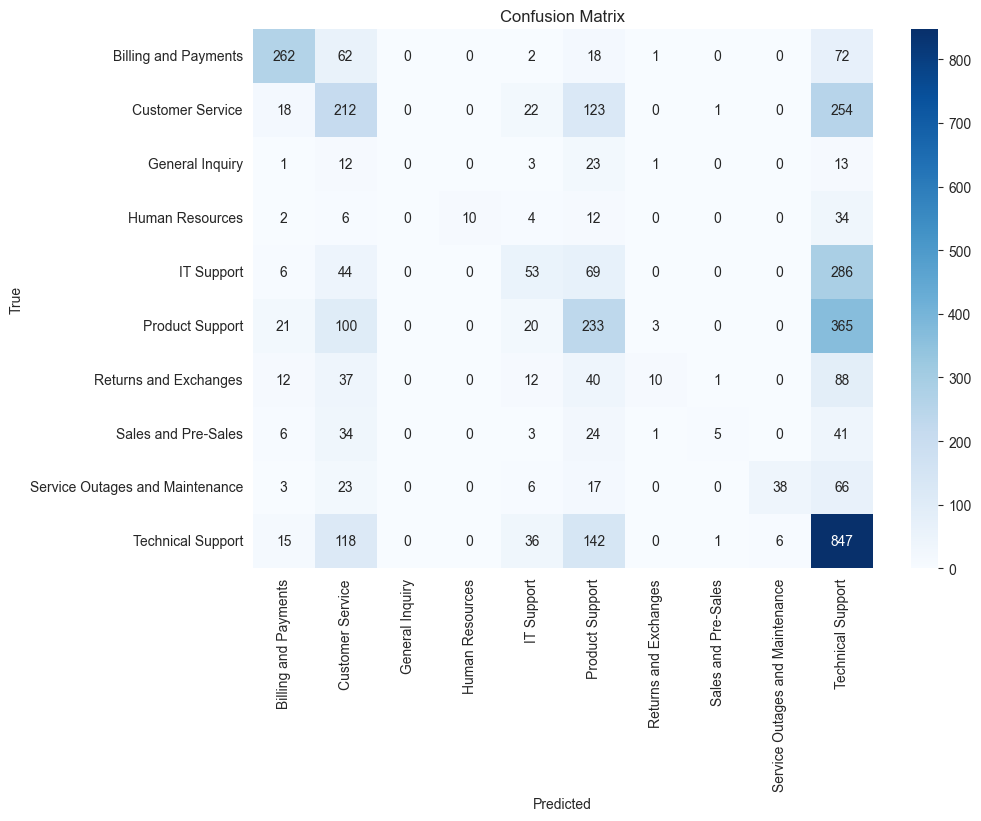

accuracy = 0.4175
Macro F1: 0.2854
Weighted F1: 0.3821
                                 precision    recall  f1-score   support

           Billing and Payments       0.76      0.63      0.69       417
               Customer Service       0.33      0.34      0.33       630
                General Inquiry       0.00      0.00      0.00        53
                Human Resources       1.00      0.15      0.26        68
                     IT Support       0.33      0.12      0.17       458
                Product Support       0.33      0.31      0.32       742
          Returns and Exchanges       0.62      0.05      0.09       200
            Sales and Pre-Sales       0.62      0.04      0.08       114
Service Outages and Maintenance       0.86      0.25      0.39       153
              Technical Support       0.41      0.73      0.52      1165

                       accuracy                           0.42      4000
                      macro avg       0.53      0.26      0.29     

/Users/nathanpollet/Desktop/mistralAI/mistral_final/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/nathanpollet/Desktop/mistralAI/mistral_final/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/nathanpollet/Desktop/mistralAI/mistral_final/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

In [ ]:
y_pred = clf.predict(X_test_tfidf)
cm = confusion_matrix(y_test_enc, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    xticklabels=label_encoder.classes_,
    yticklabels=label_encoder.classes_,
    cmap="Blues",
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

print(f"accuracy = {accuracy_score(y_test_enc, y_pred)}")
macro_f1 = f1_score(y_test_enc, y_pred, average="macro")
weighted_f1 = f1_score(y_test_enc, y_pred, average="weighted")
print(f"Macro F1: {macro_f1:.4f}")
print(f"Weighted F1: {weighted_f1:.4f}")
print(classification_report(y_test_enc, y_pred, target_names=label_encoder.classes_))

Run inference on balanced eval set

accuracy = 0.2528
Macro F1: 0.2395
Weighted F1: 0.2395
                                 precision    recall  f1-score   support

           Billing and Payments       0.77      0.64      0.70        53
               Customer Service       0.18      0.32      0.23        53
                General Inquiry       0.00      0.00      0.00        53
                Human Resources       1.00      0.15      0.26        53
                     IT Support       0.19      0.09      0.13        53
                Product Support       0.09      0.19      0.12        53
          Returns and Exchanges       0.33      0.02      0.04        53
            Sales and Pre-Sales       1.00      0.08      0.14        53
Service Outages and Maintenance       1.00      0.34      0.51        53
              Technical Support       0.17      0.70      0.27        53

                       accuracy                           0.25       530
                      macro avg       0.47      0.25      0.24     

/Users/nathanpollet/Desktop/mistralAI/mistral_final/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/nathanpollet/Desktop/mistralAI/mistral_final/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/nathanpollet/Desktop/mistralAI/mistral_final/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

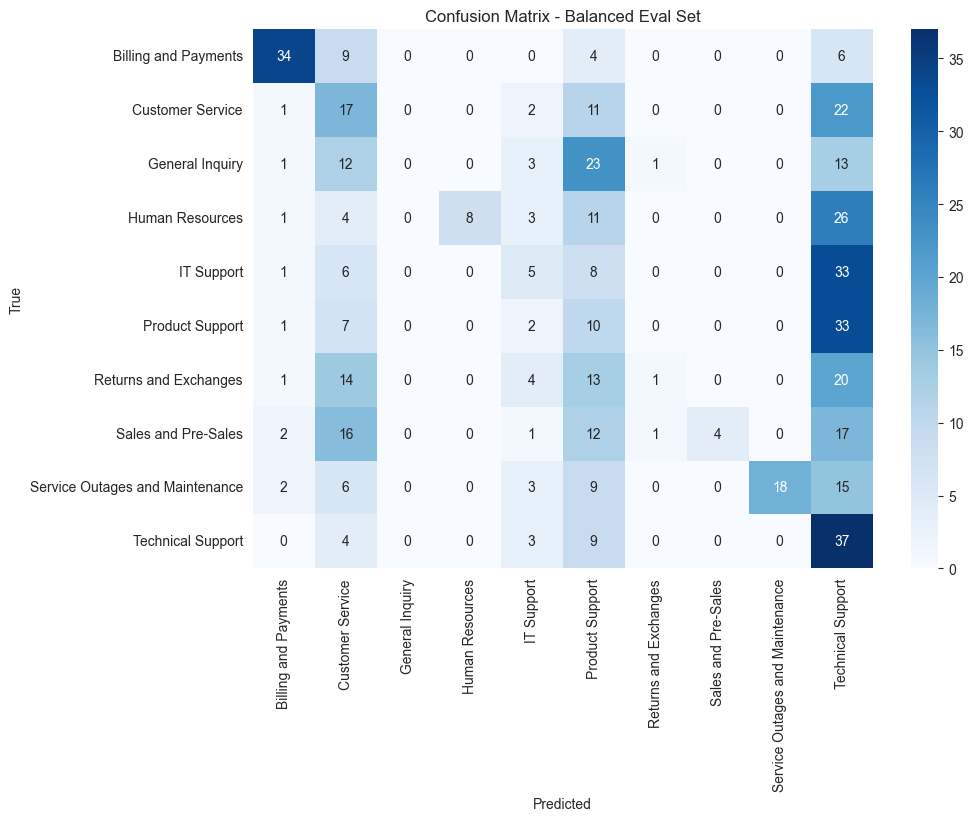

In [ ]:
X_eval = balanced_eval_df["text"].astype(str)
X_eval_tfidf = vectorizer.transform(X_eval)

y_eval_true = label_encoder.transform(balanced_eval_df["queue"])
y_eval_pred = clf.predict(X_eval_tfidf)

print(f"accuracy = {accuracy_score(y_eval_true, y_eval_pred):.4f}")
print(f"Macro F1: {f1_score(y_eval_true, y_eval_pred, average='macro'):.4f}")
print(f"Weighted F1: {f1_score(y_eval_true, y_eval_pred, average='weighted'):.4f}")
print(classification_report(y_eval_true, y_eval_pred, target_names=label_encoder.classes_))

cm = confusion_matrix(y_eval_true, y_eval_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    xticklabels=label_encoder.classes_,
    yticklabels=label_encoder.classes_,
    cmap="Blues",
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Balanced Eval Set")
plt.show()

#### Addressing class imbalance

In [ ]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(max_iter=1000, class_weight='balanced')

In [ ]:
clf.fit(X_train_tfidf, y_train_enc)

LogisticRegression(class_weight='balanced', max_iter=1000)

accuracy = 0.35
Macro F1: 0.3179
Weighted F1: 0.3585
                                 precision    recall  f1-score   support

           Billing and Payments       0.66      0.70      0.68       417
               Customer Service       0.33      0.27      0.30       630
                General Inquiry       0.10      0.36      0.16        53
                Human Resources       0.19      0.50      0.27        68
                     IT Support       0.30      0.32      0.31       458
                Product Support       0.37      0.23      0.28       742
          Returns and Exchanges       0.16      0.28      0.20       200
            Sales and Pre-Sales       0.15      0.43      0.23       114
Service Outages and Maintenance       0.26      0.52      0.35       153
              Technical Support       0.51      0.33      0.40      1165

                       accuracy                           0.35      4000
                      macro avg       0.30      0.39      0.32      4

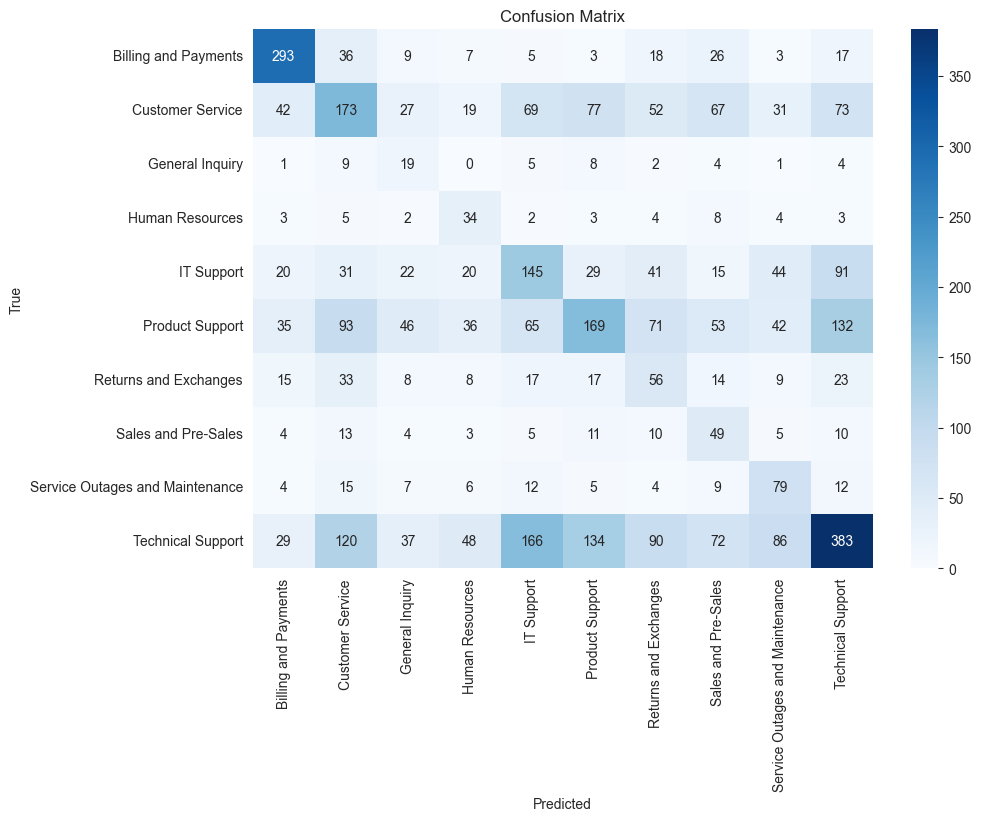

In [ ]:
y_pred = clf.predict(X_test_tfidf)

print(f"accuracy = {accuracy_score(y_test_enc, y_pred)}")
macro_f1 = f1_score(y_test_enc, y_pred, average="macro")
weighted_f1 = f1_score(y_test_enc, y_pred, average="weighted")
print(f"Macro F1: {macro_f1:.4f}")
print(f"Weighted F1: {weighted_f1:.4f}")
print(classification_report(y_test_enc, y_pred, target_names=label_encoder.classes_))

cm = confusion_matrix(y_test_enc, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    xticklabels=label_encoder.classes_,
    yticklabels=label_encoder.classes_,
    cmap="Blues",
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

On balanced eval set

accuracy = 0.3698
Macro F1: 0.3712
Weighted F1: 0.3712
                                 precision    recall  f1-score   support

           Billing and Payments       0.66      0.74      0.70        53
               Customer Service       0.19      0.28      0.23        53
                General Inquiry       0.45      0.36      0.40        53
                Human Resources       0.62      0.45      0.52        53
                     IT Support       0.30      0.26      0.28        53
                Product Support       0.13      0.11      0.12        53
          Returns and Exchanges       0.25      0.21      0.23        53
            Sales and Pre-Sales       0.41      0.49      0.44        53
Service Outages and Maintenance       0.55      0.49      0.52        53
              Technical Support       0.24      0.30      0.27        53

                       accuracy                           0.37       530
                      macro avg       0.38      0.37      0.37     

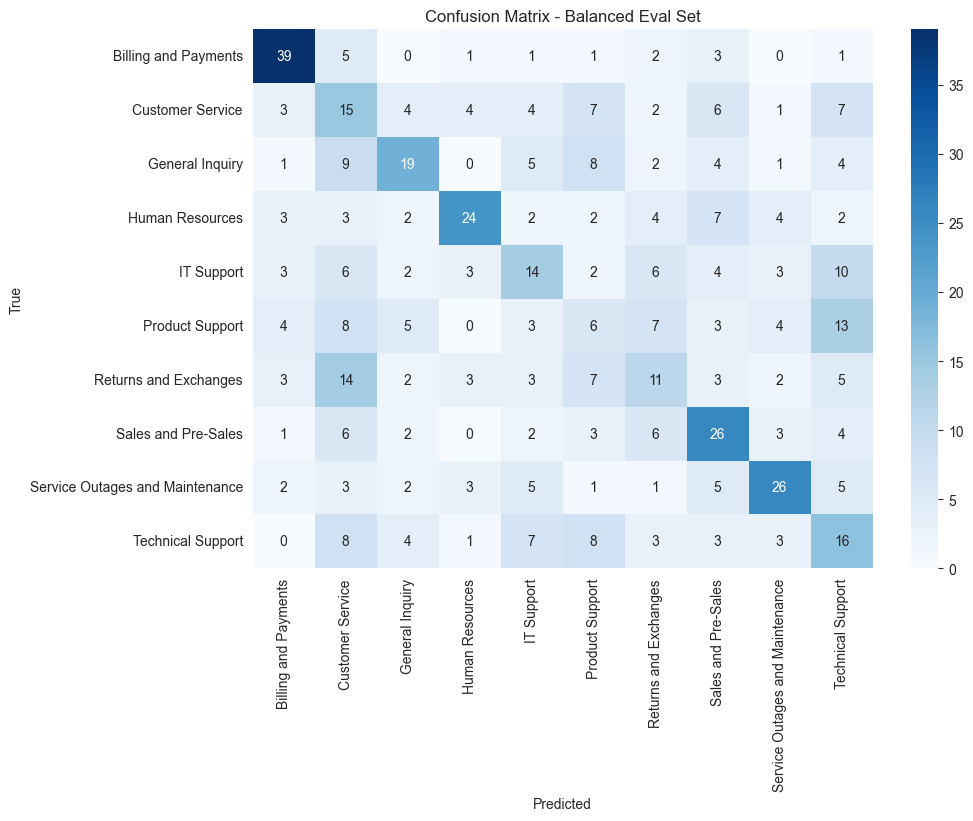

In [ ]:
X_eval = balanced_eval_df["text"].astype(str)
X_eval_tfidf = vectorizer.transform(X_eval)

y_eval_true = label_encoder.transform(balanced_eval_df["queue"])
y_eval_pred = clf.predict(X_eval_tfidf)

print(f"accuracy = {accuracy_score(y_eval_true, y_eval_pred):.4f}")
print(f"Macro F1: {f1_score(y_eval_true, y_eval_pred, average='macro'):.4f}")
print(f"Weighted F1: {f1_score(y_eval_true, y_eval_pred, average='weighted'):.4f}")
print(classification_report(y_eval_true, y_eval_pred, target_names=label_encoder.classes_))

cm = confusion_matrix(y_eval_true, y_eval_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    xticklabels=label_encoder.classes_,
    yticklabels=label_encoder.classes_,
    cmap="Blues",
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Balanced Eval Set")
plt.show()

## Non-LLM Baseline Model 2: AutoModelForSequenceClassification

In [ ]:
from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
)
import torch
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight 

In [ ]:
# Build label mappings from train_df only (avoid label leakage from test)
queue_list = sorted(train_df["queue"].unique().tolist())
label2id = {label: i for i, label in enumerate(queue_list)}
id2label = {i: label for label, i in label2id.items()}

train_df["label"] = train_df["queue"].map(label2id)
test_df["label"] = test_df["queue"].map(label2id)

train_ds = Dataset.from_pandas(
    train_df[["text", "label"]].rename(columns={"text": "text"})
)
test_ds = Dataset.from_pandas(
    test_df[["text", "label"]].rename(columns={"text": "text"})
)

In [ ]:
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_fn(batch):
    return tokenizer(batch["text"], padding="max_length", truncation=True, max_length=256)

train_ds = train_ds.map(tokenize_fn, batched=True)
test_ds = test_ds.map(tokenize_fn, batched=True)

train_ds.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
test_ds.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

from transformers import DistilBertForSequenceClassification
import torch.nn as nn

class WeightedDistilBERT(DistilBertForSequenceClassification):
    def __init__(self, config, class_weights):
        super().__init__(config)
        self.class_weights = class_weights

    def forward(self, input_ids=None, attention_mask=None, labels=None, **kwargs):
        outputs = super().forward(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=None,
            **kwargs
        )
        logits = outputs.logits
        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss(weight=self.class_weights.to(logits.device))
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
        return {"loss": loss, "logits": logits} if loss is not None else {"logits": logits}

from transformers import AutoConfig

class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(train_df["label"]),
    y=train_df["label"]
)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float)

# Build model with class weights
config = AutoConfig.from_pretrained(model_name, num_labels=len(queue_list), id2label=id2label, label2id=label2id)
model = WeightedDistilBERT.from_pretrained(model_name, config=config, class_weights=class_weights_tensor)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    report = classification_report(
        labels,
        preds,
        labels=list(range(len(queue_list))),
        target_names=queue_list,
        output_dict=True,
    )
    return {
        "accuracy": report["accuracy"],
        "macro_f1": report["macro avg"]["f1-score"],
        "weighted_f1": report["weighted avg"]["f1-score"],
    }

training_args = TrainingArguments(
    output_dir="./transformer_baseline",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    learning_rate=2e-5,
    weight_decay=0.01,
    logging_steps=10,
    save_total_limit=1,
    load_best_model_at_end=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    compute_metrics=compute_metrics,
)

trainer.train()

Map: 100%|██████████| 4000/4000 [00:00<00:00, 6626.97 examples/s]
/Users/nathanpollet/Desktop/mistralAI/mistral_final/lib/python3.9/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of WeightedDistilBERT were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/nathanpollet/Desktop/mistralAI/mistral_final/lib/python3.9/site-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
  0%|   

{'loss': 2.2956, 'grad_norm': 2.7257604598999023, 'learning_rate': 1.9933333333333334e-05, 'epoch': 0.01}


  1%|          | 20/3000 [00:14<30:08,  1.65it/s]

{'loss': 2.2857, 'grad_norm': 3.658959150314331, 'learning_rate': 1.9866666666666667e-05, 'epoch': 0.02}


  1%|          | 30/3000 [00:20<30:17,  1.63it/s]

{'loss': 2.3287, 'grad_norm': 2.916342258453369, 'learning_rate': 1.98e-05, 'epoch': 0.03}


  1%|▏         | 40/3000 [00:26<29:57,  1.65it/s]

{'loss': 2.2703, 'grad_norm': 3.2453513145446777, 'learning_rate': 1.9733333333333336e-05, 'epoch': 0.04}


  2%|▏         | 50/3000 [00:32<29:44,  1.65it/s]

{'loss': 2.3051, 'grad_norm': 3.4975757598876953, 'learning_rate': 1.9666666666666666e-05, 'epoch': 0.05}


  2%|▏         | 60/3000 [00:38<30:08,  1.63it/s]

{'loss': 2.1703, 'grad_norm': 3.2752645015716553, 'learning_rate': 1.9600000000000002e-05, 'epoch': 0.06}


  2%|▏         | 70/3000 [00:44<29:07,  1.68it/s]

{'loss': 2.1761, 'grad_norm': 5.209772109985352, 'learning_rate': 1.9533333333333335e-05, 'epoch': 0.07}


  3%|▎         | 80/3000 [00:51<30:05,  1.62it/s]

{'loss': 2.3594, 'grad_norm': 3.994194507598877, 'learning_rate': 1.9466666666666668e-05, 'epoch': 0.08}


  3%|▎         | 90/3000 [00:57<29:09,  1.66it/s]

{'loss': 2.378, 'grad_norm': 4.360691547393799, 'learning_rate': 1.94e-05, 'epoch': 0.09}


  3%|▎         | 100/3000 [01:03<29:34,  1.63it/s]

{'loss': 2.3816, 'grad_norm': 5.209447383880615, 'learning_rate': 1.9333333333333333e-05, 'epoch': 0.1}


  4%|▎         | 110/3000 [01:09<30:17,  1.59it/s]

{'loss': 2.3042, 'grad_norm': 4.775691032409668, 'learning_rate': 1.926666666666667e-05, 'epoch': 0.11}


  4%|▍         | 120/3000 [01:15<28:56,  1.66it/s]

{'loss': 2.2441, 'grad_norm': 3.6576740741729736, 'learning_rate': 1.9200000000000003e-05, 'epoch': 0.12}


  4%|▍         | 130/3000 [01:21<28:53,  1.66it/s]

{'loss': 2.2294, 'grad_norm': 3.429121494293213, 'learning_rate': 1.9133333333333335e-05, 'epoch': 0.13}


  5%|▍         | 140/3000 [01:27<29:09,  1.63it/s]

{'loss': 2.2305, 'grad_norm': 4.693971633911133, 'learning_rate': 1.9066666666666668e-05, 'epoch': 0.14}


  5%|▌         | 150/3000 [01:34<28:57,  1.64it/s]

{'loss': 2.314, 'grad_norm': 4.539451599121094, 'learning_rate': 1.9e-05, 'epoch': 0.15}


  5%|▌         | 160/3000 [01:40<28:44,  1.65it/s]

{'loss': 2.2089, 'grad_norm': 5.828730583190918, 'learning_rate': 1.8933333333333334e-05, 'epoch': 0.16}


  6%|▌         | 170/3000 [01:46<28:14,  1.67it/s]

{'loss': 2.252, 'grad_norm': 3.5933003425598145, 'learning_rate': 1.886666666666667e-05, 'epoch': 0.17}


  6%|▌         | 180/3000 [01:52<28:16,  1.66it/s]

{'loss': 2.2506, 'grad_norm': 4.304105758666992, 'learning_rate': 1.88e-05, 'epoch': 0.18}


  6%|▋         | 190/3000 [01:58<29:14,  1.60it/s]

{'loss': 2.2148, 'grad_norm': 3.6785366535186768, 'learning_rate': 1.8733333333333336e-05, 'epoch': 0.19}


  7%|▋         | 200/3000 [02:04<27:32,  1.69it/s]

{'loss': 2.1918, 'grad_norm': 3.7772953510284424, 'learning_rate': 1.866666666666667e-05, 'epoch': 0.2}


  7%|▋         | 210/3000 [02:10<27:37,  1.68it/s]

{'loss': 2.2015, 'grad_norm': 4.175792217254639, 'learning_rate': 1.86e-05, 'epoch': 0.21}


  7%|▋         | 220/3000 [02:16<27:42,  1.67it/s]

{'loss': 2.2429, 'grad_norm': 4.649766445159912, 'learning_rate': 1.8533333333333334e-05, 'epoch': 0.22}


  8%|▊         | 230/3000 [02:22<28:19,  1.63it/s]

{'loss': 2.1274, 'grad_norm': 2.7924699783325195, 'learning_rate': 1.8466666666666667e-05, 'epoch': 0.23}


  8%|▊         | 240/3000 [02:28<28:08,  1.63it/s]

{'loss': 2.1499, 'grad_norm': 4.056840419769287, 'learning_rate': 1.8400000000000003e-05, 'epoch': 0.24}


  8%|▊         | 250/3000 [02:34<28:01,  1.64it/s]

{'loss': 2.2051, 'grad_norm': 4.628086090087891, 'learning_rate': 1.8333333333333333e-05, 'epoch': 0.25}


  9%|▊         | 260/3000 [02:41<29:38,  1.54it/s]

{'loss': 2.1588, 'grad_norm': 5.929550647735596, 'learning_rate': 1.826666666666667e-05, 'epoch': 0.26}


  9%|▉         | 270/3000 [02:47<28:26,  1.60it/s]

{'loss': 2.196, 'grad_norm': 5.087509632110596, 'learning_rate': 1.8200000000000002e-05, 'epoch': 0.27}


  9%|▉         | 280/3000 [02:53<27:24,  1.65it/s]

{'loss': 2.2261, 'grad_norm': 4.916280746459961, 'learning_rate': 1.8133333333333335e-05, 'epoch': 0.28}


 10%|▉         | 290/3000 [02:59<27:55,  1.62it/s]

{'loss': 2.1864, 'grad_norm': 5.122697830200195, 'learning_rate': 1.8066666666666668e-05, 'epoch': 0.29}


 10%|█         | 300/3000 [03:06<27:32,  1.63it/s]

{'loss': 2.1691, 'grad_norm': 4.254566669464111, 'learning_rate': 1.8e-05, 'epoch': 0.3}


 10%|█         | 310/3000 [03:12<27:46,  1.61it/s]

{'loss': 2.0355, 'grad_norm': 5.971311569213867, 'learning_rate': 1.7933333333333333e-05, 'epoch': 0.31}


 11%|█         | 320/3000 [03:18<27:43,  1.61it/s]

{'loss': 2.0795, 'grad_norm': 5.346206188201904, 'learning_rate': 1.7866666666666666e-05, 'epoch': 0.32}


 11%|█         | 330/3000 [03:24<26:44,  1.66it/s]

{'loss': 2.1692, 'grad_norm': 6.971174716949463, 'learning_rate': 1.7800000000000002e-05, 'epoch': 0.33}


 11%|█▏        | 340/3000 [03:30<27:08,  1.63it/s]

{'loss': 2.0295, 'grad_norm': 4.434657096862793, 'learning_rate': 1.7733333333333335e-05, 'epoch': 0.34}


 12%|█▏        | 350/3000 [03:36<27:53,  1.58it/s]

{'loss': 2.1419, 'grad_norm': 4.072935104370117, 'learning_rate': 1.7666666666666668e-05, 'epoch': 0.35}


 12%|█▏        | 360/3000 [03:43<26:21,  1.67it/s]

{'loss': 2.1398, 'grad_norm': 3.2991671562194824, 'learning_rate': 1.76e-05, 'epoch': 0.36}


 12%|█▏        | 370/3000 [03:49<26:33,  1.65it/s]

{'loss': 2.1704, 'grad_norm': 4.337084770202637, 'learning_rate': 1.7533333333333337e-05, 'epoch': 0.37}


 13%|█▎        | 380/3000 [03:55<27:28,  1.59it/s]

{'loss': 2.1493, 'grad_norm': 4.274227142333984, 'learning_rate': 1.7466666666666667e-05, 'epoch': 0.38}


 13%|█▎        | 390/3000 [04:01<25:56,  1.68it/s]

{'loss': 2.1013, 'grad_norm': 3.4413955211639404, 'learning_rate': 1.7400000000000003e-05, 'epoch': 0.39}


 13%|█▎        | 400/3000 [04:07<26:16,  1.65it/s]

{'loss': 2.1451, 'grad_norm': 6.801745891571045, 'learning_rate': 1.7333333333333336e-05, 'epoch': 0.4}


 14%|█▎        | 410/3000 [04:13<25:42,  1.68it/s]

{'loss': 2.1772, 'grad_norm': 6.488500118255615, 'learning_rate': 1.726666666666667e-05, 'epoch': 0.41}


 14%|█▍        | 420/3000 [04:19<25:20,  1.70it/s]

{'loss': 2.053, 'grad_norm': 5.249702453613281, 'learning_rate': 1.72e-05, 'epoch': 0.42}


 14%|█▍        | 430/3000 [04:25<26:48,  1.60it/s]

{'loss': 2.1772, 'grad_norm': 4.540463924407959, 'learning_rate': 1.7133333333333334e-05, 'epoch': 0.43}


 15%|█▍        | 440/3000 [04:31<26:12,  1.63it/s]

{'loss': 2.1243, 'grad_norm': 5.225100994110107, 'learning_rate': 1.706666666666667e-05, 'epoch': 0.44}


 15%|█▌        | 450/3000 [04:37<26:05,  1.63it/s]

{'loss': 2.08, 'grad_norm': 4.418342590332031, 'learning_rate': 1.7e-05, 'epoch': 0.45}


 15%|█▌        | 460/3000 [04:43<25:57,  1.63it/s]

{'loss': 2.0456, 'grad_norm': 2.973752737045288, 'learning_rate': 1.6933333333333336e-05, 'epoch': 0.46}


 16%|█▌        | 470/3000 [04:50<26:39,  1.58it/s]

{'loss': 2.0365, 'grad_norm': 4.811718940734863, 'learning_rate': 1.686666666666667e-05, 'epoch': 0.47}


 16%|█▌        | 480/3000 [04:56<26:21,  1.59it/s]

{'loss': 2.0421, 'grad_norm': 5.079024791717529, 'learning_rate': 1.6800000000000002e-05, 'epoch': 0.48}


 16%|█▋        | 490/3000 [05:03<25:40,  1.63it/s]

{'loss': 2.1284, 'grad_norm': 3.701338768005371, 'learning_rate': 1.6733333333333335e-05, 'epoch': 0.49}


 17%|█▋        | 500/3000 [05:09<24:54,  1.67it/s]

{'loss': 1.8714, 'grad_norm': 4.720098972320557, 'learning_rate': 1.6666666666666667e-05, 'epoch': 0.5}


 17%|█▋        | 510/3000 [05:15<24:47,  1.67it/s]

{'loss': 2.0925, 'grad_norm': 8.902749061584473, 'learning_rate': 1.66e-05, 'epoch': 0.51}


 17%|█▋        | 520/3000 [05:21<24:57,  1.66it/s]

{'loss': 2.0443, 'grad_norm': 6.5412702560424805, 'learning_rate': 1.6533333333333333e-05, 'epoch': 0.52}


 18%|█▊        | 530/3000 [05:27<25:09,  1.64it/s]

{'loss': 2.1374, 'grad_norm': 7.404802322387695, 'learning_rate': 1.646666666666667e-05, 'epoch': 0.53}


 18%|█▊        | 540/3000 [05:33<24:18,  1.69it/s]

{'loss': 2.0622, 'grad_norm': 4.41434907913208, 'learning_rate': 1.64e-05, 'epoch': 0.54}


 18%|█▊        | 550/3000 [05:39<24:58,  1.63it/s]

{'loss': 2.0005, 'grad_norm': 4.832180976867676, 'learning_rate': 1.6333333333333335e-05, 'epoch': 0.55}


 19%|█▊        | 560/3000 [05:45<24:53,  1.63it/s]

{'loss': 2.0012, 'grad_norm': 4.938592910766602, 'learning_rate': 1.6266666666666668e-05, 'epoch': 0.56}


 19%|█▉        | 570/3000 [05:52<25:01,  1.62it/s]

{'loss': 2.0772, 'grad_norm': 6.404397964477539, 'learning_rate': 1.62e-05, 'epoch': 0.57}


 19%|█▉        | 580/3000 [05:58<25:18,  1.59it/s]

{'loss': 2.0494, 'grad_norm': 4.29243803024292, 'learning_rate': 1.6133333333333334e-05, 'epoch': 0.58}


 20%|█▉        | 590/3000 [06:04<24:30,  1.64it/s]

{'loss': 2.0896, 'grad_norm': 6.26973819732666, 'learning_rate': 1.606666666666667e-05, 'epoch': 0.59}


 20%|██        | 600/3000 [06:10<24:58,  1.60it/s]

{'loss': 2.13, 'grad_norm': 5.8165764808654785, 'learning_rate': 1.6000000000000003e-05, 'epoch': 0.6}


 20%|██        | 610/3000 [06:17<25:02,  1.59it/s]

{'loss': 1.9554, 'grad_norm': 5.09574031829834, 'learning_rate': 1.5933333333333336e-05, 'epoch': 0.61}


 21%|██        | 620/3000 [06:23<23:48,  1.67it/s]

{'loss': 2.1399, 'grad_norm': 5.0341949462890625, 'learning_rate': 1.586666666666667e-05, 'epoch': 0.62}


 21%|██        | 630/3000 [06:29<24:08,  1.64it/s]

{'loss': 2.1947, 'grad_norm': 7.746234893798828, 'learning_rate': 1.58e-05, 'epoch': 0.63}


 21%|██▏       | 640/3000 [06:35<23:57,  1.64it/s]

{'loss': 2.0979, 'grad_norm': 5.829328536987305, 'learning_rate': 1.5733333333333334e-05, 'epoch': 0.64}


 22%|██▏       | 650/3000 [06:41<24:40,  1.59it/s]

{'loss': 2.0516, 'grad_norm': 5.685219764709473, 'learning_rate': 1.5666666666666667e-05, 'epoch': 0.65}


 22%|██▏       | 660/3000 [06:47<24:01,  1.62it/s]

{'loss': 2.1447, 'grad_norm': 5.378170013427734, 'learning_rate': 1.5600000000000003e-05, 'epoch': 0.66}


 22%|██▏       | 670/3000 [06:54<25:28,  1.52it/s]

{'loss': 1.9844, 'grad_norm': 3.5910637378692627, 'learning_rate': 1.5533333333333333e-05, 'epoch': 0.67}


 23%|██▎       | 680/3000 [07:01<24:29,  1.58it/s]

{'loss': 2.0729, 'grad_norm': 6.408186912536621, 'learning_rate': 1.546666666666667e-05, 'epoch': 0.68}


 23%|██▎       | 690/3000 [07:07<22:43,  1.69it/s]

{'loss': 2.0266, 'grad_norm': 6.139950752258301, 'learning_rate': 1.54e-05, 'epoch': 0.69}


 23%|██▎       | 700/3000 [07:13<23:18,  1.64it/s]

{'loss': 1.9488, 'grad_norm': 6.457363605499268, 'learning_rate': 1.5333333333333334e-05, 'epoch': 0.7}


 24%|██▎       | 710/3000 [07:19<24:02,  1.59it/s]

{'loss': 2.0877, 'grad_norm': 7.019565105438232, 'learning_rate': 1.5266666666666667e-05, 'epoch': 0.71}


 24%|██▍       | 720/3000 [07:25<23:07,  1.64it/s]

{'loss': 1.9377, 'grad_norm': 6.5786285400390625, 'learning_rate': 1.5200000000000002e-05, 'epoch': 0.72}


 24%|██▍       | 730/3000 [07:31<22:24,  1.69it/s]

{'loss': 2.0865, 'grad_norm': 4.836508750915527, 'learning_rate': 1.5133333333333335e-05, 'epoch': 0.73}


 25%|██▍       | 740/3000 [07:37<23:08,  1.63it/s]

{'loss': 1.9969, 'grad_norm': 5.0001373291015625, 'learning_rate': 1.5066666666666668e-05, 'epoch': 0.74}


 25%|██▌       | 750/3000 [07:43<23:51,  1.57it/s]

{'loss': 2.1679, 'grad_norm': 7.521150588989258, 'learning_rate': 1.5000000000000002e-05, 'epoch': 0.75}


 25%|██▌       | 760/3000 [07:49<22:07,  1.69it/s]

{'loss': 2.0331, 'grad_norm': 3.9060745239257812, 'learning_rate': 1.4933333333333335e-05, 'epoch': 0.76}


 26%|██▌       | 770/3000 [07:55<22:09,  1.68it/s]

{'loss': 2.1014, 'grad_norm': 6.022496700286865, 'learning_rate': 1.4866666666666668e-05, 'epoch': 0.77}


 26%|██▌       | 780/3000 [08:01<22:08,  1.67it/s]

{'loss': 1.9429, 'grad_norm': 4.306221961975098, 'learning_rate': 1.48e-05, 'epoch': 0.78}


 26%|██▋       | 790/3000 [08:07<21:52,  1.68it/s]

{'loss': 2.0314, 'grad_norm': 4.492798328399658, 'learning_rate': 1.4733333333333335e-05, 'epoch': 0.79}


 27%|██▋       | 800/3000 [08:13<22:25,  1.64it/s]

{'loss': 2.0862, 'grad_norm': 7.2188191413879395, 'learning_rate': 1.4666666666666666e-05, 'epoch': 0.8}


 27%|██▋       | 810/3000 [08:20<22:00,  1.66it/s]

{'loss': 2.0967, 'grad_norm': 5.62614107131958, 'learning_rate': 1.46e-05, 'epoch': 0.81}


 27%|██▋       | 820/3000 [08:26<21:51,  1.66it/s]

{'loss': 1.955, 'grad_norm': 3.9320051670074463, 'learning_rate': 1.4533333333333335e-05, 'epoch': 0.82}


 28%|██▊       | 830/3000 [08:32<21:22,  1.69it/s]

{'loss': 2.0952, 'grad_norm': 7.729252815246582, 'learning_rate': 1.4466666666666668e-05, 'epoch': 0.83}


 28%|██▊       | 840/3000 [08:38<22:43,  1.58it/s]

{'loss': 2.1741, 'grad_norm': 5.401730060577393, 'learning_rate': 1.4400000000000001e-05, 'epoch': 0.84}


 28%|██▊       | 850/3000 [08:44<21:41,  1.65it/s]

{'loss': 1.9638, 'grad_norm': 5.128213405609131, 'learning_rate': 1.4333333333333334e-05, 'epoch': 0.85}


 29%|██▊       | 860/3000 [08:50<21:35,  1.65it/s]

{'loss': 2.0234, 'grad_norm': 6.832418441772461, 'learning_rate': 1.4266666666666668e-05, 'epoch': 0.86}


 29%|██▉       | 870/3000 [08:56<21:18,  1.67it/s]

{'loss': 1.905, 'grad_norm': 5.346518039703369, 'learning_rate': 1.4200000000000001e-05, 'epoch': 0.87}


 29%|██▉       | 880/3000 [09:02<21:51,  1.62it/s]

{'loss': 1.9927, 'grad_norm': 7.306212902069092, 'learning_rate': 1.4133333333333334e-05, 'epoch': 0.88}


 30%|██▉       | 890/3000 [09:08<21:06,  1.67it/s]

{'loss': 1.8857, 'grad_norm': 5.682937145233154, 'learning_rate': 1.4066666666666669e-05, 'epoch': 0.89}


 30%|███       | 900/3000 [09:14<20:53,  1.68it/s]

{'loss': 1.9184, 'grad_norm': 6.096678256988525, 'learning_rate': 1.4e-05, 'epoch': 0.9}


 30%|███       | 910/3000 [09:20<20:46,  1.68it/s]

{'loss': 2.183, 'grad_norm': 9.174843788146973, 'learning_rate': 1.3933333333333334e-05, 'epoch': 0.91}


 31%|███       | 920/3000 [09:26<20:58,  1.65it/s]

{'loss': 2.1346, 'grad_norm': 5.581978797912598, 'learning_rate': 1.3866666666666669e-05, 'epoch': 0.92}


 31%|███       | 930/3000 [09:32<20:57,  1.65it/s]

{'loss': 2.0767, 'grad_norm': 8.186237335205078, 'learning_rate': 1.38e-05, 'epoch': 0.93}


 31%|███▏      | 940/3000 [09:39<21:16,  1.61it/s]

{'loss': 2.0392, 'grad_norm': 8.018896102905273, 'learning_rate': 1.3733333333333335e-05, 'epoch': 0.94}


 32%|███▏      | 950/3000 [09:45<20:36,  1.66it/s]

{'loss': 1.864, 'grad_norm': 5.862875461578369, 'learning_rate': 1.3666666666666667e-05, 'epoch': 0.95}


 32%|███▏      | 960/3000 [09:51<20:37,  1.65it/s]

{'loss': 2.0101, 'grad_norm': 5.5074005126953125, 'learning_rate': 1.3600000000000002e-05, 'epoch': 0.96}


 32%|███▏      | 970/3000 [09:57<21:26,  1.58it/s]

{'loss': 2.0768, 'grad_norm': 11.28966236114502, 'learning_rate': 1.3533333333333333e-05, 'epoch': 0.97}


 33%|███▎      | 980/3000 [10:03<20:16,  1.66it/s]

{'loss': 1.9903, 'grad_norm': 7.122635364532471, 'learning_rate': 1.3466666666666668e-05, 'epoch': 0.98}


 33%|███▎      | 990/3000 [10:09<20:17,  1.65it/s]

{'loss': 1.8964, 'grad_norm': 9.361948013305664, 'learning_rate': 1.3400000000000002e-05, 'epoch': 0.99}


 33%|███▎      | 1000/3000 [10:15<19:51,  1.68it/s]

{'loss': 2.054, 'grad_norm': 5.56491231918335, 'learning_rate': 1.3333333333333333e-05, 'epoch': 1.0}


/Users/nathanpollet/Desktop/mistralAI/mistral_final/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/nathanpollet/Desktop/mistralAI/mistral_final/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/nathanpollet/Desktop/mistralAI/mistral_final/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

{'eval_loss': 1.9823569059371948, 'eval_accuracy': 0.30625, 'eval_macro_f1': 0.22858524501556293, 'eval_weighted_f1': 0.29819690470537985, 'eval_runtime': 42.6398, 'eval_samples_per_second': 93.809, 'eval_steps_per_second': 2.932, 'epoch': 1.0}


 34%|███▎      | 1010/3000 [11:06<37:54,  1.14s/it]  

{'loss': 1.8502, 'grad_norm': 5.863493919372559, 'learning_rate': 1.3266666666666668e-05, 'epoch': 1.01}


 34%|███▍      | 1020/3000 [11:12<20:40,  1.60it/s]

{'loss': 1.8858, 'grad_norm': 5.835988998413086, 'learning_rate': 1.3200000000000002e-05, 'epoch': 1.02}


 34%|███▍      | 1030/3000 [11:18<19:53,  1.65it/s]

{'loss': 1.7958, 'grad_norm': 8.07608413696289, 'learning_rate': 1.3133333333333334e-05, 'epoch': 1.03}


 35%|███▍      | 1040/3000 [11:24<19:58,  1.64it/s]

{'loss': 1.9408, 'grad_norm': 11.592534065246582, 'learning_rate': 1.3066666666666668e-05, 'epoch': 1.04}


 35%|███▌      | 1050/3000 [11:30<20:11,  1.61it/s]

{'loss': 1.9971, 'grad_norm': 5.629626274108887, 'learning_rate': 1.3000000000000001e-05, 'epoch': 1.05}


 35%|███▌      | 1060/3000 [11:37<19:44,  1.64it/s]

{'loss': 1.9589, 'grad_norm': 4.449641227722168, 'learning_rate': 1.2933333333333334e-05, 'epoch': 1.06}


 36%|███▌      | 1070/3000 [11:43<19:35,  1.64it/s]

{'loss': 1.7641, 'grad_norm': 3.0880980491638184, 'learning_rate': 1.2866666666666667e-05, 'epoch': 1.07}


 36%|███▌      | 1080/3000 [11:49<19:46,  1.62it/s]

{'loss': 2.0111, 'grad_norm': 5.977596282958984, 'learning_rate': 1.2800000000000001e-05, 'epoch': 1.08}


 36%|███▋      | 1090/3000 [11:55<19:27,  1.64it/s]

{'loss': 1.9982, 'grad_norm': 7.8501129150390625, 'learning_rate': 1.2733333333333336e-05, 'epoch': 1.09}


 37%|███▋      | 1100/3000 [12:01<19:01,  1.66it/s]

{'loss': 1.9283, 'grad_norm': 4.404535293579102, 'learning_rate': 1.2666666666666667e-05, 'epoch': 1.1}


 37%|███▋      | 1110/3000 [12:07<18:53,  1.67it/s]

{'loss': 2.0733, 'grad_norm': 9.16597843170166, 'learning_rate': 1.2600000000000001e-05, 'epoch': 1.11}


 37%|███▋      | 1120/3000 [12:13<18:52,  1.66it/s]

{'loss': 1.9319, 'grad_norm': 7.589605808258057, 'learning_rate': 1.2533333333333336e-05, 'epoch': 1.12}


 38%|███▊      | 1130/3000 [12:20<19:09,  1.63it/s]

{'loss': 2.0314, 'grad_norm': 7.554965972900391, 'learning_rate': 1.2466666666666667e-05, 'epoch': 1.13}


 38%|███▊      | 1140/3000 [12:26<18:32,  1.67it/s]

{'loss': 2.0196, 'grad_norm': 5.4203104972839355, 'learning_rate': 1.2400000000000002e-05, 'epoch': 1.14}


 38%|███▊      | 1150/3000 [12:32<18:13,  1.69it/s]

{'loss': 1.9728, 'grad_norm': 5.200467586517334, 'learning_rate': 1.2333333333333334e-05, 'epoch': 1.15}


 39%|███▊      | 1160/3000 [12:38<18:26,  1.66it/s]

{'loss': 1.9512, 'grad_norm': 7.18501091003418, 'learning_rate': 1.2266666666666667e-05, 'epoch': 1.16}


 39%|███▉      | 1170/3000 [12:44<18:28,  1.65it/s]

{'loss': 1.9907, 'grad_norm': 8.819061279296875, 'learning_rate': 1.22e-05, 'epoch': 1.17}


 39%|███▉      | 1180/3000 [12:50<18:07,  1.67it/s]

{'loss': 1.7452, 'grad_norm': 4.562429904937744, 'learning_rate': 1.2133333333333335e-05, 'epoch': 1.18}


 40%|███▉      | 1190/3000 [12:56<17:49,  1.69it/s]

{'loss': 1.7962, 'grad_norm': 8.7090482711792, 'learning_rate': 1.206666666666667e-05, 'epoch': 1.19}


 40%|████      | 1200/3000 [13:02<17:54,  1.67it/s]

{'loss': 1.9555, 'grad_norm': 4.909654140472412, 'learning_rate': 1.2e-05, 'epoch': 1.2}


 40%|████      | 1210/3000 [13:08<18:00,  1.66it/s]

{'loss': 1.9354, 'grad_norm': 5.090780735015869, 'learning_rate': 1.1933333333333335e-05, 'epoch': 1.21}


 41%|████      | 1220/3000 [13:14<17:53,  1.66it/s]

{'loss': 1.8371, 'grad_norm': 5.628774166107178, 'learning_rate': 1.186666666666667e-05, 'epoch': 1.22}


 41%|████      | 1230/3000 [13:20<17:48,  1.66it/s]

{'loss': 1.9811, 'grad_norm': 9.809450149536133, 'learning_rate': 1.18e-05, 'epoch': 1.23}


 41%|████▏     | 1240/3000 [13:26<17:30,  1.68it/s]

{'loss': 1.7641, 'grad_norm': 5.220813274383545, 'learning_rate': 1.1733333333333335e-05, 'epoch': 1.24}


 42%|████▏     | 1250/3000 [13:32<17:09,  1.70it/s]

{'loss': 1.8864, 'grad_norm': 5.697664737701416, 'learning_rate': 1.1666666666666668e-05, 'epoch': 1.25}


 42%|████▏     | 1260/3000 [13:38<17:42,  1.64it/s]

{'loss': 1.8771, 'grad_norm': 7.932008743286133, 'learning_rate': 1.16e-05, 'epoch': 1.26}


 42%|████▏     | 1270/3000 [13:44<17:44,  1.63it/s]

{'loss': 1.8199, 'grad_norm': 7.8523125648498535, 'learning_rate': 1.1533333333333334e-05, 'epoch': 1.27}


 43%|████▎     | 1280/3000 [13:50<17:22,  1.65it/s]

{'loss': 1.9813, 'grad_norm': 12.114872932434082, 'learning_rate': 1.1466666666666668e-05, 'epoch': 1.28}


 43%|████▎     | 1290/3000 [13:56<17:12,  1.66it/s]

{'loss': 2.0056, 'grad_norm': 13.505431175231934, 'learning_rate': 1.14e-05, 'epoch': 1.29}


 43%|████▎     | 1300/3000 [14:02<17:00,  1.67it/s]

{'loss': 1.8934, 'grad_norm': 6.487798690795898, 'learning_rate': 1.1333333333333334e-05, 'epoch': 1.3}


 44%|████▎     | 1310/3000 [14:08<16:37,  1.69it/s]

{'loss': 1.6999, 'grad_norm': 6.597742557525635, 'learning_rate': 1.1266666666666668e-05, 'epoch': 1.31}


 44%|████▍     | 1320/3000 [14:14<16:35,  1.69it/s]

{'loss': 1.9111, 'grad_norm': 4.5382513999938965, 'learning_rate': 1.1200000000000001e-05, 'epoch': 1.32}


 44%|████▍     | 1330/3000 [14:20<16:23,  1.70it/s]

{'loss': 1.7877, 'grad_norm': 6.487301349639893, 'learning_rate': 1.1133333333333334e-05, 'epoch': 1.33}


 45%|████▍     | 1340/3000 [14:26<16:29,  1.68it/s]

{'loss': 1.7852, 'grad_norm': 7.367372512817383, 'learning_rate': 1.1066666666666669e-05, 'epoch': 1.34}


 45%|████▌     | 1350/3000 [14:32<16:31,  1.66it/s]

{'loss': 1.9272, 'grad_norm': 4.90889310836792, 'learning_rate': 1.1000000000000001e-05, 'epoch': 1.35}


 45%|████▌     | 1360/3000 [14:38<16:04,  1.70it/s]

{'loss': 1.813, 'grad_norm': 7.08887243270874, 'learning_rate': 1.0933333333333334e-05, 'epoch': 1.36}


 46%|████▌     | 1370/3000 [14:44<16:20,  1.66it/s]

{'loss': 1.953, 'grad_norm': 5.369739055633545, 'learning_rate': 1.0866666666666667e-05, 'epoch': 1.37}


 46%|████▌     | 1380/3000 [14:50<16:15,  1.66it/s]

{'loss': 1.6768, 'grad_norm': 5.738529682159424, 'learning_rate': 1.0800000000000002e-05, 'epoch': 1.38}


 46%|████▋     | 1390/3000 [14:56<15:58,  1.68it/s]

{'loss': 1.8371, 'grad_norm': 7.108755588531494, 'learning_rate': 1.0733333333333333e-05, 'epoch': 1.39}


 47%|████▋     | 1400/3000 [15:02<16:06,  1.66it/s]

{'loss': 2.0733, 'grad_norm': 6.751580238342285, 'learning_rate': 1.0666666666666667e-05, 'epoch': 1.4}


 47%|████▋     | 1410/3000 [15:08<16:12,  1.64it/s]

{'loss': 1.7874, 'grad_norm': 7.5222673416137695, 'learning_rate': 1.0600000000000002e-05, 'epoch': 1.41}


 47%|████▋     | 1420/3000 [15:14<15:39,  1.68it/s]

{'loss': 1.9533, 'grad_norm': 5.891559600830078, 'learning_rate': 1.0533333333333333e-05, 'epoch': 1.42}


 48%|████▊     | 1430/3000 [15:20<16:11,  1.62it/s]

{'loss': 1.9328, 'grad_norm': 9.144116401672363, 'learning_rate': 1.0466666666666668e-05, 'epoch': 1.43}


 48%|████▊     | 1440/3000 [15:26<16:18,  1.59it/s]

{'loss': 1.8903, 'grad_norm': 6.331881046295166, 'learning_rate': 1.04e-05, 'epoch': 1.44}


 48%|████▊     | 1450/3000 [15:32<15:35,  1.66it/s]

{'loss': 1.9059, 'grad_norm': 10.57801342010498, 'learning_rate': 1.0333333333333335e-05, 'epoch': 1.45}


 49%|████▊     | 1460/3000 [15:38<15:59,  1.61it/s]

{'loss': 1.8703, 'grad_norm': 5.302905082702637, 'learning_rate': 1.0266666666666668e-05, 'epoch': 1.46}


 49%|████▉     | 1470/3000 [15:44<15:18,  1.67it/s]

{'loss': 1.8128, 'grad_norm': 10.018414497375488, 'learning_rate': 1.02e-05, 'epoch': 1.47}


 49%|████▉     | 1480/3000 [15:50<15:12,  1.67it/s]

{'loss': 2.0206, 'grad_norm': 5.061209201812744, 'learning_rate': 1.0133333333333335e-05, 'epoch': 1.48}


 50%|████▉     | 1490/3000 [15:56<15:08,  1.66it/s]

{'loss': 1.9714, 'grad_norm': 5.473067283630371, 'learning_rate': 1.0066666666666666e-05, 'epoch': 1.49}


 50%|█████     | 1500/3000 [16:02<14:59,  1.67it/s]

{'loss': 1.8316, 'grad_norm': 9.425240516662598, 'learning_rate': 1e-05, 'epoch': 1.5}


 50%|█████     | 1510/3000 [16:09<15:26,  1.61it/s]

{'loss': 1.9495, 'grad_norm': 9.189141273498535, 'learning_rate': 9.933333333333334e-06, 'epoch': 1.51}


 51%|█████     | 1520/3000 [16:15<15:50,  1.56it/s]

{'loss': 1.8019, 'grad_norm': 8.506806373596191, 'learning_rate': 9.866666666666668e-06, 'epoch': 1.52}


 51%|█████     | 1530/3000 [16:21<14:47,  1.66it/s]

{'loss': 1.8717, 'grad_norm': 8.264008522033691, 'learning_rate': 9.800000000000001e-06, 'epoch': 1.53}


 51%|█████▏    | 1540/3000 [16:27<15:11,  1.60it/s]

{'loss': 1.9049, 'grad_norm': 11.184906959533691, 'learning_rate': 9.733333333333334e-06, 'epoch': 1.54}


 52%|█████▏    | 1550/3000 [16:33<14:26,  1.67it/s]

{'loss': 1.7795, 'grad_norm': 6.761251926422119, 'learning_rate': 9.666666666666667e-06, 'epoch': 1.55}


 52%|█████▏    | 1560/3000 [16:40<14:37,  1.64it/s]

{'loss': 1.9748, 'grad_norm': 6.867840766906738, 'learning_rate': 9.600000000000001e-06, 'epoch': 1.56}


 52%|█████▏    | 1570/3000 [16:46<14:20,  1.66it/s]

{'loss': 1.9479, 'grad_norm': 7.629475116729736, 'learning_rate': 9.533333333333334e-06, 'epoch': 1.57}


 53%|█████▎    | 1580/3000 [16:52<14:46,  1.60it/s]

{'loss': 1.8936, 'grad_norm': 6.937442779541016, 'learning_rate': 9.466666666666667e-06, 'epoch': 1.58}


 53%|█████▎    | 1590/3000 [16:58<14:12,  1.65it/s]

{'loss': 2.0557, 'grad_norm': 8.819276809692383, 'learning_rate': 9.4e-06, 'epoch': 1.59}


 53%|█████▎    | 1600/3000 [17:04<14:35,  1.60it/s]

{'loss': 1.7087, 'grad_norm': 4.641712665557861, 'learning_rate': 9.333333333333334e-06, 'epoch': 1.6}


 54%|█████▎    | 1610/3000 [17:10<14:40,  1.58it/s]

{'loss': 1.7112, 'grad_norm': 5.773305892944336, 'learning_rate': 9.266666666666667e-06, 'epoch': 1.61}


 54%|█████▍    | 1620/3000 [17:16<14:11,  1.62it/s]

{'loss': 1.739, 'grad_norm': 6.515130043029785, 'learning_rate': 9.200000000000002e-06, 'epoch': 1.62}


 54%|█████▍    | 1630/3000 [17:22<13:37,  1.68it/s]

{'loss': 1.8891, 'grad_norm': 13.385921478271484, 'learning_rate': 9.133333333333335e-06, 'epoch': 1.63}


 55%|█████▍    | 1640/3000 [17:28<13:57,  1.62it/s]

{'loss': 1.7042, 'grad_norm': 5.573990345001221, 'learning_rate': 9.066666666666667e-06, 'epoch': 1.64}


 55%|█████▌    | 1650/3000 [17:35<14:00,  1.61it/s]

{'loss': 2.0668, 'grad_norm': 9.757883071899414, 'learning_rate': 9e-06, 'epoch': 1.65}


 55%|█████▌    | 1660/3000 [17:41<13:50,  1.61it/s]

{'loss': 1.9685, 'grad_norm': 5.545691967010498, 'learning_rate': 8.933333333333333e-06, 'epoch': 1.66}


 56%|█████▌    | 1670/3000 [17:47<13:22,  1.66it/s]

{'loss': 2.0309, 'grad_norm': 9.390759468078613, 'learning_rate': 8.866666666666668e-06, 'epoch': 1.67}


 56%|█████▌    | 1680/3000 [17:53<13:31,  1.63it/s]

{'loss': 1.7595, 'grad_norm': 10.236387252807617, 'learning_rate': 8.8e-06, 'epoch': 1.68}


 56%|█████▋    | 1690/3000 [17:59<13:13,  1.65it/s]

{'loss': 1.7616, 'grad_norm': 6.768287658691406, 'learning_rate': 8.733333333333333e-06, 'epoch': 1.69}


 57%|█████▋    | 1700/3000 [18:05<13:07,  1.65it/s]

{'loss': 1.8074, 'grad_norm': 7.915379524230957, 'learning_rate': 8.666666666666668e-06, 'epoch': 1.7}


 57%|█████▋    | 1710/3000 [18:11<12:53,  1.67it/s]

{'loss': 1.7184, 'grad_norm': 7.565346717834473, 'learning_rate': 8.6e-06, 'epoch': 1.71}


 57%|█████▋    | 1720/3000 [18:18<12:54,  1.65it/s]

{'loss': 1.8053, 'grad_norm': 7.209375858306885, 'learning_rate': 8.533333333333335e-06, 'epoch': 1.72}


 58%|█████▊    | 1730/3000 [18:24<12:52,  1.64it/s]

{'loss': 1.84, 'grad_norm': 6.502810955047607, 'learning_rate': 8.466666666666668e-06, 'epoch': 1.73}


 58%|█████▊    | 1740/3000 [18:30<13:00,  1.61it/s]

{'loss': 1.8088, 'grad_norm': 7.970771789550781, 'learning_rate': 8.400000000000001e-06, 'epoch': 1.74}


 58%|█████▊    | 1750/3000 [18:36<12:29,  1.67it/s]

{'loss': 1.834, 'grad_norm': 7.290569305419922, 'learning_rate': 8.333333333333334e-06, 'epoch': 1.75}


 59%|█████▊    | 1760/3000 [18:42<12:36,  1.64it/s]

{'loss': 1.7928, 'grad_norm': 5.597127437591553, 'learning_rate': 8.266666666666667e-06, 'epoch': 1.76}


 59%|█████▉    | 1770/3000 [18:48<12:36,  1.63it/s]

{'loss': 1.8043, 'grad_norm': 9.145177841186523, 'learning_rate': 8.2e-06, 'epoch': 1.77}


 59%|█████▉    | 1780/3000 [18:54<12:32,  1.62it/s]

{'loss': 1.8115, 'grad_norm': 10.449954986572266, 'learning_rate': 8.133333333333334e-06, 'epoch': 1.78}


 60%|█████▉    | 1790/3000 [19:00<12:10,  1.66it/s]

{'loss': 1.752, 'grad_norm': 8.281965255737305, 'learning_rate': 8.066666666666667e-06, 'epoch': 1.79}


 60%|██████    | 1800/3000 [19:06<11:57,  1.67it/s]

{'loss': 1.9088, 'grad_norm': 8.745080947875977, 'learning_rate': 8.000000000000001e-06, 'epoch': 1.8}


 60%|██████    | 1810/3000 [19:12<11:54,  1.66it/s]

{'loss': 1.9068, 'grad_norm': 11.242568969726562, 'learning_rate': 7.933333333333334e-06, 'epoch': 1.81}


 61%|██████    | 1820/3000 [19:18<11:45,  1.67it/s]

{'loss': 1.8738, 'grad_norm': 7.56441068649292, 'learning_rate': 7.866666666666667e-06, 'epoch': 1.82}


 61%|██████    | 1830/3000 [19:24<11:42,  1.66it/s]

{'loss': 1.6689, 'grad_norm': 11.864508628845215, 'learning_rate': 7.800000000000002e-06, 'epoch': 1.83}


 61%|██████▏   | 1840/3000 [19:30<11:37,  1.66it/s]

{'loss': 1.8713, 'grad_norm': 11.08420467376709, 'learning_rate': 7.733333333333334e-06, 'epoch': 1.84}


 62%|██████▏   | 1850/3000 [19:36<11:27,  1.67it/s]

{'loss': 1.8139, 'grad_norm': 5.83773136138916, 'learning_rate': 7.666666666666667e-06, 'epoch': 1.85}


 62%|██████▏   | 1860/3000 [19:42<11:15,  1.69it/s]

{'loss': 2.1139, 'grad_norm': 8.670737266540527, 'learning_rate': 7.600000000000001e-06, 'epoch': 1.86}


 62%|██████▏   | 1870/3000 [19:48<11:10,  1.69it/s]

{'loss': 1.896, 'grad_norm': 8.593222618103027, 'learning_rate': 7.533333333333334e-06, 'epoch': 1.87}


 63%|██████▎   | 1880/3000 [19:54<11:08,  1.68it/s]

{'loss': 1.6739, 'grad_norm': 9.659551620483398, 'learning_rate': 7.4666666666666675e-06, 'epoch': 1.88}


 63%|██████▎   | 1890/3000 [20:00<10:51,  1.70it/s]

{'loss': 1.8568, 'grad_norm': 10.795689582824707, 'learning_rate': 7.4e-06, 'epoch': 1.89}


 63%|██████▎   | 1900/3000 [20:06<10:45,  1.71it/s]

{'loss': 1.9046, 'grad_norm': 10.550686836242676, 'learning_rate': 7.333333333333333e-06, 'epoch': 1.9}


 64%|██████▎   | 1910/3000 [20:12<10:58,  1.66it/s]

{'loss': 1.8141, 'grad_norm': 16.8344669342041, 'learning_rate': 7.266666666666668e-06, 'epoch': 1.91}


 64%|██████▍   | 1920/3000 [20:18<10:42,  1.68it/s]

{'loss': 1.5358, 'grad_norm': 7.953066825866699, 'learning_rate': 7.2000000000000005e-06, 'epoch': 1.92}


 64%|██████▍   | 1930/3000 [20:24<10:45,  1.66it/s]

{'loss': 1.7239, 'grad_norm': 7.123324394226074, 'learning_rate': 7.133333333333334e-06, 'epoch': 1.93}


 65%|██████▍   | 1940/3000 [20:30<10:26,  1.69it/s]

{'loss': 1.7623, 'grad_norm': 16.240856170654297, 'learning_rate': 7.066666666666667e-06, 'epoch': 1.94}


 65%|██████▌   | 1950/3000 [20:36<10:25,  1.68it/s]

{'loss': 1.939, 'grad_norm': 6.802609443664551, 'learning_rate': 7e-06, 'epoch': 1.95}


 65%|██████▌   | 1960/3000 [20:42<10:19,  1.68it/s]

{'loss': 1.8571, 'grad_norm': 11.475676536560059, 'learning_rate': 6.9333333333333344e-06, 'epoch': 1.96}


 66%|██████▌   | 1970/3000 [20:48<10:11,  1.69it/s]

{'loss': 1.8003, 'grad_norm': 4.910493850708008, 'learning_rate': 6.866666666666667e-06, 'epoch': 1.97}


 66%|██████▌   | 1980/3000 [20:55<10:55,  1.56it/s]

{'loss': 2.0395, 'grad_norm': 10.838937759399414, 'learning_rate': 6.800000000000001e-06, 'epoch': 1.98}


 66%|██████▋   | 1990/3000 [21:00<09:58,  1.69it/s]

{'loss': 1.8909, 'grad_norm': 12.03951644897461, 'learning_rate': 6.733333333333334e-06, 'epoch': 1.99}


 67%|██████▋   | 2000/3000 [21:06<09:57,  1.67it/s]

{'loss': 1.7832, 'grad_norm': 10.734064102172852, 'learning_rate': 6.666666666666667e-06, 'epoch': 2.0}


                                                   
 67%|██████▋   | 2000/3000 [21:47<09:57,  1.67it/s]

{'eval_loss': 1.878942608833313, 'eval_accuracy': 0.308, 'eval_macro_f1': 0.28502327301117786, 'eval_weighted_f1': 0.316570723645297, 'eval_runtime': 40.2268, 'eval_samples_per_second': 99.436, 'eval_steps_per_second': 3.107, 'epoch': 2.0}


 67%|██████▋   | 2010/3000 [21:55<18:35,  1.13s/it]  

{'loss': 1.8144, 'grad_norm': 13.728886604309082, 'learning_rate': 6.600000000000001e-06, 'epoch': 2.01}


 67%|██████▋   | 2020/3000 [22:01<10:22,  1.57it/s]

{'loss': 1.7289, 'grad_norm': 14.882726669311523, 'learning_rate': 6.533333333333334e-06, 'epoch': 2.02}


 68%|██████▊   | 2030/3000 [22:07<09:48,  1.65it/s]

{'loss': 1.6898, 'grad_norm': 8.452184677124023, 'learning_rate': 6.466666666666667e-06, 'epoch': 2.03}


 68%|██████▊   | 2040/3000 [22:13<09:31,  1.68it/s]

{'loss': 1.6565, 'grad_norm': 6.20682430267334, 'learning_rate': 6.4000000000000006e-06, 'epoch': 2.04}


 68%|██████▊   | 2050/3000 [22:19<09:28,  1.67it/s]

{'loss': 1.8392, 'grad_norm': 7.223418712615967, 'learning_rate': 6.333333333333333e-06, 'epoch': 2.05}


 69%|██████▊   | 2060/3000 [22:25<09:31,  1.65it/s]

{'loss': 1.7172, 'grad_norm': 5.944705009460449, 'learning_rate': 6.266666666666668e-06, 'epoch': 2.06}


 69%|██████▉   | 2070/3000 [22:31<09:25,  1.64it/s]

{'loss': 1.7346, 'grad_norm': 14.056635856628418, 'learning_rate': 6.200000000000001e-06, 'epoch': 2.07}


 69%|██████▉   | 2080/3000 [22:37<09:23,  1.63it/s]

{'loss': 1.63, 'grad_norm': 5.4754862785339355, 'learning_rate': 6.133333333333334e-06, 'epoch': 2.08}


 70%|██████▉   | 2090/3000 [22:43<09:14,  1.64it/s]

{'loss': 1.7003, 'grad_norm': 21.161218643188477, 'learning_rate': 6.066666666666667e-06, 'epoch': 2.09}


 70%|███████   | 2100/3000 [22:50<09:09,  1.64it/s]

{'loss': 1.7941, 'grad_norm': 10.221272468566895, 'learning_rate': 6e-06, 'epoch': 2.1}


 70%|███████   | 2110/3000 [22:56<09:14,  1.60it/s]

{'loss': 1.8089, 'grad_norm': 10.683053016662598, 'learning_rate': 5.933333333333335e-06, 'epoch': 2.11}


 71%|███████   | 2120/3000 [23:02<09:04,  1.62it/s]

{'loss': 1.6925, 'grad_norm': 6.6463165283203125, 'learning_rate': 5.8666666666666675e-06, 'epoch': 2.12}


 71%|███████   | 2130/3000 [23:08<08:54,  1.63it/s]

{'loss': 1.8535, 'grad_norm': 9.366443634033203, 'learning_rate': 5.8e-06, 'epoch': 2.13}


 71%|███████▏  | 2140/3000 [23:14<08:36,  1.66it/s]

{'loss': 1.8063, 'grad_norm': 9.185802459716797, 'learning_rate': 5.733333333333334e-06, 'epoch': 2.14}


 72%|███████▏  | 2150/3000 [23:20<08:33,  1.65it/s]

{'loss': 1.6662, 'grad_norm': 8.314806938171387, 'learning_rate': 5.666666666666667e-06, 'epoch': 2.15}


 72%|███████▏  | 2160/3000 [23:26<08:19,  1.68it/s]

{'loss': 1.7846, 'grad_norm': 12.87741470336914, 'learning_rate': 5.600000000000001e-06, 'epoch': 2.16}


 72%|███████▏  | 2170/3000 [23:32<08:17,  1.67it/s]

{'loss': 1.8655, 'grad_norm': 10.876672744750977, 'learning_rate': 5.533333333333334e-06, 'epoch': 2.17}


 73%|███████▎  | 2180/3000 [23:38<08:12,  1.67it/s]

{'loss': 1.6102, 'grad_norm': 10.852849960327148, 'learning_rate': 5.466666666666667e-06, 'epoch': 2.18}


 73%|███████▎  | 2190/3000 [23:44<08:02,  1.68it/s]

{'loss': 1.7722, 'grad_norm': 15.576868057250977, 'learning_rate': 5.400000000000001e-06, 'epoch': 2.19}


 73%|███████▎  | 2200/3000 [23:50<08:01,  1.66it/s]

{'loss': 1.7199, 'grad_norm': 3.833635091781616, 'learning_rate': 5.333333333333334e-06, 'epoch': 2.2}


 74%|███████▎  | 2210/3000 [23:56<07:55,  1.66it/s]

{'loss': 1.7973, 'grad_norm': 6.435760021209717, 'learning_rate': 5.2666666666666665e-06, 'epoch': 2.21}


 74%|███████▍  | 2220/3000 [24:02<07:44,  1.68it/s]

{'loss': 1.545, 'grad_norm': 6.76781702041626, 'learning_rate': 5.2e-06, 'epoch': 2.22}


 74%|███████▍  | 2230/3000 [24:08<07:41,  1.67it/s]

{'loss': 1.8858, 'grad_norm': 6.659146308898926, 'learning_rate': 5.133333333333334e-06, 'epoch': 2.23}


 75%|███████▍  | 2240/3000 [24:14<07:57,  1.59it/s]

{'loss': 1.8409, 'grad_norm': 10.485998153686523, 'learning_rate': 5.0666666666666676e-06, 'epoch': 2.24}


 75%|███████▌  | 2250/3000 [24:20<07:34,  1.65it/s]

{'loss': 1.7612, 'grad_norm': 6.923942565917969, 'learning_rate': 5e-06, 'epoch': 2.25}


 75%|███████▌  | 2260/3000 [24:26<07:30,  1.64it/s]

{'loss': 1.7568, 'grad_norm': 12.063186645507812, 'learning_rate': 4.933333333333334e-06, 'epoch': 2.26}


 76%|███████▌  | 2270/3000 [24:32<07:40,  1.59it/s]

{'loss': 1.8595, 'grad_norm': 13.103135108947754, 'learning_rate': 4.866666666666667e-06, 'epoch': 2.27}


 76%|███████▌  | 2280/3000 [24:39<07:28,  1.60it/s]

{'loss': 1.654, 'grad_norm': 12.315442085266113, 'learning_rate': 4.800000000000001e-06, 'epoch': 2.28}


 76%|███████▋  | 2290/3000 [24:45<07:12,  1.64it/s]

{'loss': 1.7533, 'grad_norm': 5.844622611999512, 'learning_rate': 4.7333333333333335e-06, 'epoch': 2.29}


 77%|███████▋  | 2300/3000 [24:51<07:07,  1.64it/s]

{'loss': 1.7659, 'grad_norm': 10.059456825256348, 'learning_rate': 4.666666666666667e-06, 'epoch': 2.3}


 77%|███████▋  | 2310/3000 [24:57<07:02,  1.63it/s]

{'loss': 1.6275, 'grad_norm': 10.394303321838379, 'learning_rate': 4.600000000000001e-06, 'epoch': 2.31}


 77%|███████▋  | 2320/3000 [25:03<06:48,  1.66it/s]

{'loss': 1.663, 'grad_norm': 5.708730697631836, 'learning_rate': 4.533333333333334e-06, 'epoch': 2.32}


 78%|███████▊  | 2330/3000 [25:09<06:47,  1.64it/s]

{'loss': 1.6696, 'grad_norm': 7.842414855957031, 'learning_rate': 4.4666666666666665e-06, 'epoch': 2.33}


 78%|███████▊  | 2340/3000 [25:15<06:38,  1.66it/s]

{'loss': 1.6291, 'grad_norm': 6.527716159820557, 'learning_rate': 4.4e-06, 'epoch': 2.34}


 78%|███████▊  | 2350/3000 [25:21<06:27,  1.68it/s]

{'loss': 1.634, 'grad_norm': 6.492064476013184, 'learning_rate': 4.333333333333334e-06, 'epoch': 2.35}


 79%|███████▊  | 2360/3000 [25:27<06:22,  1.67it/s]

{'loss': 1.7154, 'grad_norm': 8.776121139526367, 'learning_rate': 4.266666666666668e-06, 'epoch': 2.36}


 79%|███████▉  | 2370/3000 [25:34<06:33,  1.60it/s]

{'loss': 1.6539, 'grad_norm': 6.646394729614258, 'learning_rate': 4.2000000000000004e-06, 'epoch': 2.37}


 79%|███████▉  | 2380/3000 [25:40<06:13,  1.66it/s]

{'loss': 1.686, 'grad_norm': 6.783534526824951, 'learning_rate': 4.133333333333333e-06, 'epoch': 2.38}


 80%|███████▉  | 2390/3000 [25:46<06:05,  1.67it/s]

{'loss': 1.5986, 'grad_norm': 5.818539142608643, 'learning_rate': 4.066666666666667e-06, 'epoch': 2.39}


 80%|████████  | 2400/3000 [25:52<06:05,  1.64it/s]

{'loss': 1.5498, 'grad_norm': 8.066267013549805, 'learning_rate': 4.000000000000001e-06, 'epoch': 2.4}


 80%|████████  | 2410/3000 [25:58<05:58,  1.65it/s]

{'loss': 1.7291, 'grad_norm': 10.997426986694336, 'learning_rate': 3.9333333333333335e-06, 'epoch': 2.41}


 81%|████████  | 2420/3000 [26:04<05:57,  1.62it/s]

{'loss': 1.6649, 'grad_norm': 15.947236061096191, 'learning_rate': 3.866666666666667e-06, 'epoch': 2.42}


 81%|████████  | 2430/3000 [26:10<05:43,  1.66it/s]

{'loss': 1.8837, 'grad_norm': 15.215889930725098, 'learning_rate': 3.8000000000000005e-06, 'epoch': 2.43}


 81%|████████▏ | 2440/3000 [26:16<05:37,  1.66it/s]

{'loss': 1.811, 'grad_norm': 9.819185256958008, 'learning_rate': 3.7333333333333337e-06, 'epoch': 2.44}


 82%|████████▏ | 2450/3000 [26:22<05:26,  1.68it/s]

{'loss': 1.7782, 'grad_norm': 9.379120826721191, 'learning_rate': 3.6666666666666666e-06, 'epoch': 2.45}


 82%|████████▏ | 2460/3000 [26:28<05:26,  1.65it/s]

{'loss': 1.5948, 'grad_norm': 7.984908580780029, 'learning_rate': 3.6000000000000003e-06, 'epoch': 2.46}


 82%|████████▏ | 2470/3000 [26:34<05:22,  1.65it/s]

{'loss': 1.5751, 'grad_norm': 10.826035499572754, 'learning_rate': 3.5333333333333335e-06, 'epoch': 2.47}


 83%|████████▎ | 2480/3000 [26:40<05:18,  1.63it/s]

{'loss': 1.6507, 'grad_norm': 6.615539073944092, 'learning_rate': 3.4666666666666672e-06, 'epoch': 2.48}


 83%|████████▎ | 2490/3000 [26:46<05:03,  1.68it/s]

{'loss': 1.7646, 'grad_norm': 17.682331085205078, 'learning_rate': 3.4000000000000005e-06, 'epoch': 2.49}


 83%|████████▎ | 2500/3000 [26:52<05:06,  1.63it/s]

{'loss': 1.7445, 'grad_norm': 13.835989952087402, 'learning_rate': 3.3333333333333333e-06, 'epoch': 2.5}


 84%|████████▎ | 2510/3000 [26:58<04:56,  1.65it/s]

{'loss': 1.7215, 'grad_norm': 7.5108747482299805, 'learning_rate': 3.266666666666667e-06, 'epoch': 2.51}


 84%|████████▍ | 2520/3000 [27:04<04:50,  1.65it/s]

{'loss': 1.912, 'grad_norm': 8.076567649841309, 'learning_rate': 3.2000000000000003e-06, 'epoch': 2.52}


 84%|████████▍ | 2530/3000 [27:11<04:40,  1.68it/s]

{'loss': 1.48, 'grad_norm': 14.520188331604004, 'learning_rate': 3.133333333333334e-06, 'epoch': 2.53}


 85%|████████▍ | 2540/3000 [27:16<04:31,  1.69it/s]

{'loss': 1.5676, 'grad_norm': 10.378527641296387, 'learning_rate': 3.066666666666667e-06, 'epoch': 2.54}


 85%|████████▌ | 2550/3000 [27:23<04:29,  1.67it/s]

{'loss': 1.7416, 'grad_norm': 10.486700057983398, 'learning_rate': 3e-06, 'epoch': 2.55}


 85%|████████▌ | 2560/3000 [27:29<04:31,  1.62it/s]

{'loss': 1.7932, 'grad_norm': 7.753139019012451, 'learning_rate': 2.9333333333333338e-06, 'epoch': 2.56}


 86%|████████▌ | 2570/3000 [27:35<04:19,  1.66it/s]

{'loss': 1.6512, 'grad_norm': 11.54343032836914, 'learning_rate': 2.866666666666667e-06, 'epoch': 2.57}


 86%|████████▌ | 2580/3000 [27:41<04:13,  1.66it/s]

{'loss': 1.6436, 'grad_norm': 7.188635349273682, 'learning_rate': 2.8000000000000003e-06, 'epoch': 2.58}


 86%|████████▋ | 2590/3000 [27:47<04:08,  1.65it/s]

{'loss': 1.7514, 'grad_norm': 11.099791526794434, 'learning_rate': 2.7333333333333336e-06, 'epoch': 2.59}


 87%|████████▋ | 2600/3000 [27:53<04:18,  1.55it/s]

{'loss': 1.6555, 'grad_norm': 6.101871967315674, 'learning_rate': 2.666666666666667e-06, 'epoch': 2.6}


 87%|████████▋ | 2610/3000 [28:00<04:03,  1.60it/s]

{'loss': 1.7858, 'grad_norm': 8.07986831665039, 'learning_rate': 2.6e-06, 'epoch': 2.61}


 87%|████████▋ | 2620/3000 [28:06<03:55,  1.62it/s]

{'loss': 1.751, 'grad_norm': 6.438149929046631, 'learning_rate': 2.5333333333333338e-06, 'epoch': 2.62}


 88%|████████▊ | 2630/3000 [28:12<03:49,  1.61it/s]

{'loss': 1.6234, 'grad_norm': 7.278911113739014, 'learning_rate': 2.466666666666667e-06, 'epoch': 2.63}


 88%|████████▊ | 2640/3000 [28:18<03:40,  1.63it/s]

{'loss': 1.6262, 'grad_norm': 11.556017875671387, 'learning_rate': 2.4000000000000003e-06, 'epoch': 2.64}


 88%|████████▊ | 2650/3000 [28:24<03:35,  1.63it/s]

{'loss': 1.7115, 'grad_norm': 8.6075439453125, 'learning_rate': 2.3333333333333336e-06, 'epoch': 2.65}


 89%|████████▊ | 2660/3000 [28:31<03:27,  1.64it/s]

{'loss': 1.5077, 'grad_norm': 6.146162509918213, 'learning_rate': 2.266666666666667e-06, 'epoch': 2.66}


 89%|████████▉ | 2670/3000 [28:37<03:23,  1.62it/s]

{'loss': 1.8772, 'grad_norm': 13.448844909667969, 'learning_rate': 2.2e-06, 'epoch': 2.67}


 89%|████████▉ | 2680/3000 [28:43<03:17,  1.62it/s]

{'loss': 1.6474, 'grad_norm': 7.699353218078613, 'learning_rate': 2.133333333333334e-06, 'epoch': 2.68}


 90%|████████▉ | 2690/3000 [28:49<03:10,  1.63it/s]

{'loss': 1.5607, 'grad_norm': 4.984523773193359, 'learning_rate': 2.0666666666666666e-06, 'epoch': 2.69}


 90%|█████████ | 2700/3000 [28:55<03:05,  1.62it/s]

{'loss': 1.7742, 'grad_norm': 7.162813186645508, 'learning_rate': 2.0000000000000003e-06, 'epoch': 2.7}


 90%|█████████ | 2710/3000 [29:01<02:58,  1.62it/s]

{'loss': 1.726, 'grad_norm': 12.756119728088379, 'learning_rate': 1.9333333333333336e-06, 'epoch': 2.71}


 91%|█████████ | 2720/3000 [29:08<02:53,  1.62it/s]

{'loss': 1.7957, 'grad_norm': 8.912516593933105, 'learning_rate': 1.8666666666666669e-06, 'epoch': 2.72}


 91%|█████████ | 2730/3000 [29:14<02:46,  1.62it/s]

{'loss': 1.6147, 'grad_norm': 5.19269323348999, 'learning_rate': 1.8000000000000001e-06, 'epoch': 2.73}


 91%|█████████▏| 2740/3000 [29:20<02:39,  1.63it/s]

{'loss': 1.6521, 'grad_norm': 8.807106018066406, 'learning_rate': 1.7333333333333336e-06, 'epoch': 2.74}


 92%|█████████▏| 2750/3000 [29:26<02:33,  1.63it/s]

{'loss': 1.7223, 'grad_norm': 5.840182781219482, 'learning_rate': 1.6666666666666667e-06, 'epoch': 2.75}


 92%|█████████▏| 2760/3000 [29:32<02:31,  1.58it/s]

{'loss': 1.6534, 'grad_norm': 15.653955459594727, 'learning_rate': 1.6000000000000001e-06, 'epoch': 2.76}


 92%|█████████▏| 2770/3000 [29:39<02:22,  1.61it/s]

{'loss': 1.5182, 'grad_norm': 12.878232955932617, 'learning_rate': 1.5333333333333334e-06, 'epoch': 2.77}


 93%|█████████▎| 2780/3000 [29:45<02:14,  1.63it/s]

{'loss': 1.6375, 'grad_norm': 16.610370635986328, 'learning_rate': 1.4666666666666669e-06, 'epoch': 2.78}


 93%|█████████▎| 2790/3000 [29:51<02:09,  1.62it/s]

{'loss': 1.7521, 'grad_norm': 19.06203842163086, 'learning_rate': 1.4000000000000001e-06, 'epoch': 2.79}


 93%|█████████▎| 2800/3000 [29:57<02:02,  1.64it/s]

{'loss': 1.8656, 'grad_norm': 8.003785133361816, 'learning_rate': 1.3333333333333334e-06, 'epoch': 2.8}


 94%|█████████▎| 2810/3000 [30:03<01:55,  1.64it/s]

{'loss': 1.8252, 'grad_norm': 12.5971040725708, 'learning_rate': 1.2666666666666669e-06, 'epoch': 2.81}


 94%|█████████▍| 2820/3000 [30:09<01:50,  1.62it/s]

{'loss': 1.8847, 'grad_norm': 12.080615043640137, 'learning_rate': 1.2000000000000002e-06, 'epoch': 2.82}


 94%|█████████▍| 2830/3000 [30:15<01:44,  1.63it/s]

{'loss': 1.7412, 'grad_norm': 17.085296630859375, 'learning_rate': 1.1333333333333334e-06, 'epoch': 2.83}


 95%|█████████▍| 2840/3000 [30:21<01:38,  1.63it/s]

{'loss': 1.6782, 'grad_norm': 8.829087257385254, 'learning_rate': 1.066666666666667e-06, 'epoch': 2.84}


 95%|█████████▌| 2850/3000 [30:28<01:32,  1.62it/s]

{'loss': 1.6816, 'grad_norm': 9.43746280670166, 'learning_rate': 1.0000000000000002e-06, 'epoch': 2.85}


 95%|█████████▌| 2860/3000 [30:34<01:26,  1.62it/s]

{'loss': 1.5461, 'grad_norm': 7.359766006469727, 'learning_rate': 9.333333333333334e-07, 'epoch': 2.86}


 96%|█████████▌| 2870/3000 [30:40<01:20,  1.62it/s]

{'loss': 1.6746, 'grad_norm': 17.526906967163086, 'learning_rate': 8.666666666666668e-07, 'epoch': 2.87}


 96%|█████████▌| 2880/3000 [30:46<01:13,  1.63it/s]

{'loss': 1.6512, 'grad_norm': 10.063238143920898, 'learning_rate': 8.000000000000001e-07, 'epoch': 2.88}


 96%|█████████▋| 2890/3000 [30:52<01:08,  1.61it/s]

{'loss': 1.7588, 'grad_norm': 9.932909965515137, 'learning_rate': 7.333333333333334e-07, 'epoch': 2.89}


 97%|█████████▋| 2900/3000 [30:59<01:02,  1.59it/s]

{'loss': 1.5524, 'grad_norm': 8.465002059936523, 'learning_rate': 6.666666666666667e-07, 'epoch': 2.9}


 97%|█████████▋| 2910/3000 [31:05<00:55,  1.61it/s]

{'loss': 1.4651, 'grad_norm': 7.661942958831787, 'learning_rate': 6.000000000000001e-07, 'epoch': 2.91}


 97%|█████████▋| 2920/3000 [31:11<00:49,  1.61it/s]

{'loss': 1.4148, 'grad_norm': 17.421466827392578, 'learning_rate': 5.333333333333335e-07, 'epoch': 2.92}


 98%|█████████▊| 2930/3000 [31:17<00:44,  1.57it/s]

{'loss': 1.777, 'grad_norm': 15.854194641113281, 'learning_rate': 4.666666666666667e-07, 'epoch': 2.93}


 98%|█████████▊| 2940/3000 [31:24<00:36,  1.64it/s]

{'loss': 1.7107, 'grad_norm': 7.738900184631348, 'learning_rate': 4.0000000000000003e-07, 'epoch': 2.94}


 98%|█████████▊| 2950/3000 [31:30<00:30,  1.62it/s]

{'loss': 1.6749, 'grad_norm': 17.63599395751953, 'learning_rate': 3.3333333333333335e-07, 'epoch': 2.95}


 99%|█████████▊| 2960/3000 [31:36<00:24,  1.61it/s]

{'loss': 1.7714, 'grad_norm': 12.871935844421387, 'learning_rate': 2.666666666666667e-07, 'epoch': 2.96}


 99%|█████████▉| 2970/3000 [31:42<00:18,  1.62it/s]

{'loss': 1.8087, 'grad_norm': 14.838088035583496, 'learning_rate': 2.0000000000000002e-07, 'epoch': 2.97}


 99%|█████████▉| 2980/3000 [31:48<00:12,  1.63it/s]

{'loss': 1.5645, 'grad_norm': 7.511195182800293, 'learning_rate': 1.3333333333333336e-07, 'epoch': 2.98}


100%|█████████▉| 2990/3000 [31:55<00:06,  1.61it/s]

{'loss': 1.6666, 'grad_norm': 9.395364761352539, 'learning_rate': 6.666666666666668e-08, 'epoch': 2.99}


100%|██████████| 3000/3000 [32:01<00:00,  1.61it/s]

{'loss': 1.5617, 'grad_norm': 17.429569244384766, 'learning_rate': 0.0, 'epoch': 3.0}


                                                   
100%|██████████| 3000/3000 [32:42<00:00,  1.61it/s]

{'eval_loss': 1.8613311052322388, 'eval_accuracy': 0.30575, 'eval_macro_f1': 0.2768799622962209, 'eval_weighted_f1': 0.30785798969569, 'eval_runtime': 41.1386, 'eval_samples_per_second': 97.232, 'eval_steps_per_second': 3.039, 'epoch': 3.0}


100%|██████████| 3000/3000 [32:44<00:00,  1.53it/s]

{'train_runtime': 1964.4819, 'train_samples_per_second': 24.434, 'train_steps_per_second': 1.527, 'train_loss': 1.895551063855489, 'epoch': 3.0}


TrainOutput(global_step=3000, training_loss=1.895551063855489, metrics={'train_runtime': 1964.4819, 'train_samples_per_second': 24.434, 'train_steps_per_second': 1.527, 'total_flos': 3179671142400000.0, 'train_loss': 1.895551063855489, 'epoch': 3.0})

In [ ]:
from sklearn.metrics import classification_report, accuracy_score, f1_score

preds = trainer.predict(test_ds)
logits, labels = preds.predictions, preds.label_ids
y_pred = np.argmax(logits, axis=1)

print(classification_report(labels, y_pred, target_names=queue_list))
print(f"accuracy = {accuracy_score(labels, y_pred):.4f}")
print(f"Macro F1: {f1_score(labels, y_pred, average='macro'):.4f}")
print(f"Weighted F1: {f1_score(labels, y_pred, average='weighted'):.4f}")

100%|██████████| 125/125 [00:40<00:00,  3.12it/s]

                                 precision    recall  f1-score   support

           Billing and Payments       0.62      0.72      0.67       417
               Customer Service       0.25      0.16      0.19       630
                General Inquiry       0.08      0.15      0.10        53
                Human Resources       0.20      0.31      0.24        68
                     IT Support       0.26      0.36      0.31       458
                Product Support       0.27      0.15      0.19       742
          Returns and Exchanges       0.12      0.30      0.17       200
            Sales and Pre-Sales       0.10      0.31      0.15       114
Service Outages and Maintenance       0.32      0.50      0.39       153
              Technical Support       0.45      0.30      0.36      1165

                       accuracy                           0.31      4000
                      macro avg       0.27      0.33      0.28      4000
                   weighted avg       0.34      0

On balanced eval set

In [ ]:
balanced_eval_df["label"] = balanced_eval_df["queue"].map(label2id)

balanced_ds = Dataset.from_pandas(balanced_eval_df[["text", "label"]])
balanced_ds = balanced_ds.map(tokenize_fn, batched=True)
balanced_ds.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

balanced_preds = trainer.predict(balanced_ds)
logits, labels = balanced_preds.predictions, balanced_preds.label_ids
y_pred = np.argmax(logits, axis=1)

print("[Balanced Eval Set]")
print(classification_report(labels, y_pred, target_names=queue_list))
print(f"accuracy = {accuracy_score(labels, y_pred):.4f}")
print(f"Macro F1: {f1_score(labels, y_pred, average='macro'):.4f}")
print(f"Weighted F1: {f1_score(labels, y_pred, average='weighted'):.4f}")

100%|██████████| 17/17 [00:05<00:00,  3.15it/s]

[Balanced Eval Set]
                                 precision    recall  f1-score   support

           Billing and Payments       0.62      0.72      0.67        53
               Customer Service       0.16      0.17      0.17        53
                General Inquiry       0.50      0.15      0.23        53
                Human Resources       0.60      0.28      0.38        53
                     IT Support       0.36      0.38      0.37        53
                Product Support       0.16      0.15      0.16        53
          Returns and Exchanges       0.21      0.32      0.25        53
            Sales and Pre-Sales       0.34      0.42      0.37        53
Service Outages and Maintenance       0.70      0.57      0.62        53
              Technical Support       0.22      0.32      0.26        53

                       accuracy                           0.35       530
                      macro avg       0.39      0.35      0.35       530
                   weighted a